# Project Milestone 3

# Tools

In the first part of the notebook, you can observe the primary tools we are using for the analysis. It is required to install the pandas version 1.0.5.

In [ ]:
# pip install pandas==1.0.5

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import collections
import nltk
import requests
import pickle
import warnings
import sys
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from string import punctuation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from torch import Tensor

warnings.filterwarnings('ignore')
print('pandas version: ' + pd.__version__)

pandas version: 1.1.5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_data = '/content/drive/MyDrive/Quotebank/'

The following three cells include helper functions that helped the creation of our final dataset containing the quotes about climate change. The functions include itetaring through chunks, showing the first few elements of a chunk.

In [ ]:
# loop through nb_chunks_to_read chunks (if 0, through all chunks) and apply process_function to each of them
# return the result as a dataframe
def loop_chuncks(chunks, process_function, nb_chunks_to_read=0):
  i = 0
  result = []
  columns = None
  for chunk in chunks:
    processed = process_function(chunk)
    if processed is not None:
      if not isinstance(processed, pd.Series):
        columns = processed.columns
      for r in processed.values.tolist():
        result.append(r)
    i += 1
    if i == nb_chunks_to_read:
      break
  return pd.DataFrame(result, columns=columns)

In [ ]:
# return the first 3 elements of a chunk
def chunck_head(chunk):
  return chunk.head(3)

# example (need pandas 1.0.5)
# chunks = pd.read_json(path_data + 'quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=10000)
# loop_chuncks(chunks, chunck_head, 1)

# Creation of the dataset about climate change

The creation of the dataset was executed by iterating through quotes and finding all of them that mention climate change in any matter. We used python pickles to save the extracted quotes, one for every year from 2015 until 2020. We saved the pickles on Google drive and provided the link where you can download it. We provided the code for creating the pickles and commented it, since it needs a long time to execute. The pickles served us well in terms of creating the final dataset and, thus, positively impacted the time our cells needed to run. As a result, we got 156691 quotes about climate change.

In [ ]:
# return the quotes containing one of the words in the list

words = ['global warming', 'climate change']

def contains_word_in_list(chunk):
  return chunk[chunk.quotation.str.contains('|'.join(words), case=False)]

# example (need pandas 1.0.5)
# chunks = pd.read_json(path_data + 'quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=10000)
# word_in_list_quotes = loop_chuncks(chunks, contains_word_in_list, 3)
# word_in_list_quotes.sample(3)

In [ ]:
# to load and save pickes (from the course tutorial)
def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

def save_pickle(result, file_path = 'pickle'):
    with open(file_path, 'wb') as file:
        pickle.dump(result, file)

In [ ]:
# create a pickle of the quotes about climate change for the 2020 dataset
# this have been done for the 6 datasets, commented to not re-run it (very long)
# chunks = pd.read_json(path_data + 'quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=10000)
# climate_2020 = loop_chuncks(chunks, contains_word_in_list)
# path_pickle_2020 = '/content/drive/MyDrive/pickle_2020'
# save_pickle(climate_2020, path_pickle_2020)

In [ ]:
# load the pickles
# the pickles need to be added to the drive
# download here: https://drive.google.com/drive/folders/1j1Bp1niC0_cqg1kN_LbSrA2TGnq5MTgt?usp=sharing
climate_2015 = load_pickle('/content/drive/MyDrive/pickle_2015')
climate_2016 = load_pickle('/content/drive/MyDrive/pickle_2016')
climate_2017 = load_pickle('/content/drive/MyDrive/pickle_2017')
climate_2018 = load_pickle('/content/drive/MyDrive/pickle_2018')
climate_2019 = load_pickle('/content/drive/MyDrive/pickle_2019')
climate_2020 = load_pickle('/content/drive/MyDrive/pickle_2020')
all_years_list = [climate_2015, climate_2016, climate_2017, climate_2018, climate_2019, climate_2020]
all_years = [2015, 2016, 2017, 2018, 2019, 2020]
for i in range(len(all_years)):
  all_years_list[i]['year'] = all_years[i]

In [ ]:
# create one dataframe for all the years
climate_all_years = pd.concat(all_years_list, ignore_index=True)
print(climate_all_years.shape)
climate_all_years.sample(3)

(156691, 10)


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,year
139600,2019-10-11-102368,"This is not, from my perspective, a climate ch...",Gavin Newsom,[Q461391],2019-10-11 03:15:00,1,"[[Gavin Newsom, 0.6582], [None, 0.2891], [Bill...",[https://www.msn.com/en-us/news/us/gov-newsom-...,E,2019
98736,2018-04-18-158176,We face the challenge of climate change althou...,Sheikh Hasina,[Q52183],2018-04-18 00:17:25,1,"[[Sheikh Hasina, 0.8425], [None, 0.1575]]",[http://full.gulf-times.com/story/589434/Hasin...,E,2018
112678,2019-08-21-046184,It is a nonbinding resolution that states the ...,None,[],2019-08-21 10:11:57,2,"[[None, 0.5918], [John Cooper, 0.4082]]",[http://www.nashvillescene.com/news/features/a...,E,2019


# First analyses

Following few cells show our first, basic analysis. We included the top speakers from the quotes about climate change, the words that appeared the most in our quotes, and number of climate change quotes per year.

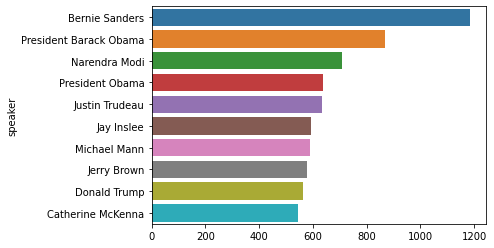

In [ ]:
# the top speakers talking about climate change
top_speakers = climate_all_years.groupby(by='speaker').count().sort_values(by='quotation', ascending=False).quotation.iloc[1:21]
sns.barplot(x=top_speakers[:10].values, y=top_speakers[0:10].index)

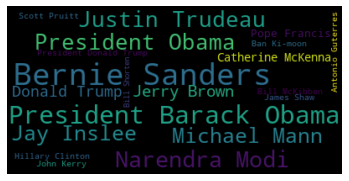

In [ ]:
# word cloud of top speakers for illustration
wordcloud = WordCloud().fit_words(dict(top_speakers))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


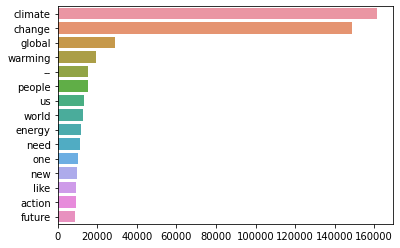

In [ ]:
# words being most used in these quotes about global warming
nltk.download('stopwords')
topic_words = collections.Counter()
stop_words = set(stopwords.words('english'))
for index, row in climate_all_years.iterrows():
    for word in row.quotation.lower().replace(',', '').replace('.', '').split():
        if word not in stop_words:
            topic_words[word] += 1
top_50_climate_words = topic_words.most_common()[:50]
sns.barplot(x=[x[1] for x in top_50_climate_words][:15], y=[x[0] for x in top_50_climate_words][:15])

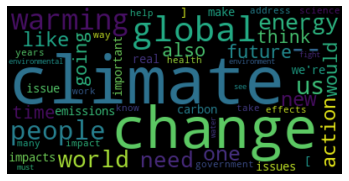

In [ ]:
# word cloud for illustration
wordcloud = WordCloud().fit_words(dict(top_50_climate_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'Quotations about global warming through time')

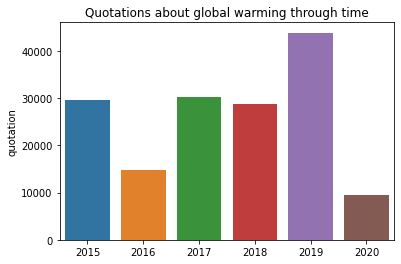

In [ ]:
# number of quotations about global warming through the years
count_years =  climate_all_years.groupby(by='year').count().quotation
sns.barplot(x=all_years, y=count_years)
plt.title("Quotations about global warming through time")

Interestingly enough, we can observe a drop of the number of quotes about climate change in the year 2020. Why?

Text(0, 0.5, '% of quotes about climate change')

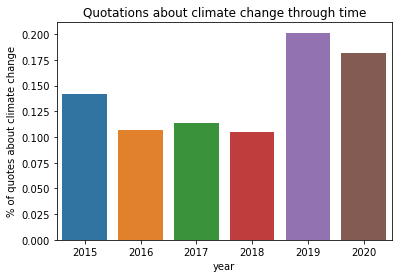

In [ ]:
# percentage of quotations about global warming through the years
total_quotes = [20874338, 13862129, 26611588, 27228451, 21763302, 5244449]
percentages = (count_years / total_quotes) * 100
# plt.figure(figsize=(10, 7))
sns.barplot(x=all_years, y=percentages)
plt.title("Quotations about climate change through time")
plt.xlabel("year")
plt.ylabel("% of quotes about climate change")

# Nationalities

This section of our notebook provided us an augmented dataframe that includes the nationality of a speaker that said something about the climate change in his or her quote. We used Wikidata to extract the information about a country and merge it with the existing quote and its speaker. This will allow us to perform different research questions analysis on speakers which origins are different, and potentially observe the difference between the groups of countries, augmented as regions.

In [ ]:
# read the wikidata file
path_data_wikidata = '/content/drive/MyDrive/speaker_attributes.parquet/'
wikidata = pd.read_parquet(path_data_wikidata)
wikidata.head(3)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None


In [ ]:
# wikidata dataframe without the None name
wikidata_clean = wikidata.dropna(axis=0, subset=['aliases'])

In [ ]:
# drop the rows with speaker None
climate_all_years_clean = climate_all_years.drop(climate_all_years.index[climate_all_years['speaker'] == 'None'])
climate_all_years_clean.shape

(108024, 10)

In [ ]:
# load the QID dataset
qids = pd.read_csv('/content/drive/MyDrive/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')
qids.head(2)

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe


We think that is important to mention that we have speakers in our dataset that have more than one nationality, so we will cover them in the following cells.

In [ ]:
# merge the quotes about global warming with the countries from wikidata using the qids
climate_countries = climate_all_years_clean.explode('qids').merge(wikidata, left_on='qids', right_on='id')
print(climate_countries.shape)
climate_countries.head(3)

(221681, 25)


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,year,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,2015-09-28-067347,man-made emissions are an insignificant part o...,John Abraham,Q313025,2015-09-28 23:16:52,1,"[[John Abraham, 0.6469], [None, 0.3092], [Will...",[http://www.desmogblog.com/donors-capital-fund],E,2015,None,[+1972-12-17T00:00:00Z],[Q668],[Q6581097],1354134367,None,None,"[Q33999, Q4610556, Q3282637, Q10800557]",None,None,Q313025,John Abraham,None,item,[Q5043]
1,2015-02-26-060320,New Study Finds Fringe Global Warming Contrari...,John Abraham,Q313025,2015-02-26 17:16:07,1,"[[John Abraham, 0.7708], [None, 0.2051], [Harr...",[http://www.globalresearch.ca/is-the-u-s-mains...,E,2015,None,[+1972-12-17T00:00:00Z],[Q668],[Q6581097],1354134367,None,None,"[Q33999, Q4610556, Q3282637, Q10800557]",None,None,Q313025,John Abraham,None,item,[Q5043]
2,2015-09-17-007663,Any argument that global warming stopped 18 or...,John Abraham,Q313025,2015-09-17 10:01:00,2,"[[John Abraham, 0.8673], [None, 0.1292], [Lama...",[http://www.environmentalhealthnews.org/t/1883...,E,2015,None,[+1972-12-17T00:00:00Z],[Q668],[Q6581097],1354134367,None,None,"[Q33999, Q4610556, Q3282637, Q10800557]",None,None,Q313025,John Abraham,None,item,[Q5043]


In [ ]:
# add the labels of the countries
climate_countries_label = climate_countries.explode('nationality').merge(qids, left_on='nationality', right_on='QID')
print(climate_countries_label.shape)
climate_countries_label.drop(columns=['id', 'label', 'Description', 'aliases', 'gender', 'lastrevid', 'ethnic_group', 
                                      'US_congress_bio_ID', 'occupation', 'academic_degree', 'candidacy', 'type', 
                                      'religion'], axis=1, inplace=True)
climate_countries_label = climate_countries_label.rename(columns={'nationality': 'nationality_qid', 
                                                                  'Label': 'nationality_label'})
climate_countries_label['nationality_label'].replace(['Ming dynasty', 'Tang Empire', "People's Republic of China", 
                                                      'Song dynasty'], 'China', inplace=True)
climate_countries_label['nationality_label'].replace('Russia', 'Russian Federation', inplace=True)
climate_countries_label.sample(3)

(178900, 27)


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,year,date_of_birth,nationality_qid,party,nationality_label
7020,2015-01-23-023770,I believe that part of being global partners m...,President Barack Obama,Q76,2015-01-23 10:47:42,2,"[[President Barack Obama, 0.835], [None, 0.165]]",[http://www.channelnewsasia.com/news/asiapacif...,E,2015,[+1961-08-04T00:00:00Z],Q30,[Q29552],United States of America
125258,2016-07-14-017849,"delivering affordable, clean energy and tackli...",Greg Clark,Q271800,2016-07-14 16:38:36,2,"[[Greg Clark, 0.8765], [None, 0.0945], [Prime ...",[https://www.carbonbrief.org/decc-folded-into-...,E,2016,[+1967-08-28T00:00:00Z],Q145,"[Q9626, Q40052]",United Kingdom
94957,2019-09-27-021654,global fleet of swarm robotics to investigate ...,James Cameron,Q6130912,2019-09-27 11:00:00,1,"[[James Cameron, 0.5506], [None, 0.4494]]",[https://www.treehugger.com/ocean-conservation...,E,2019,[+1979-09-20T00:00:00Z],Q258,None,South Africa


In [ ]:
##climate_countries_label.to_csv('climate_countries_label.csv')

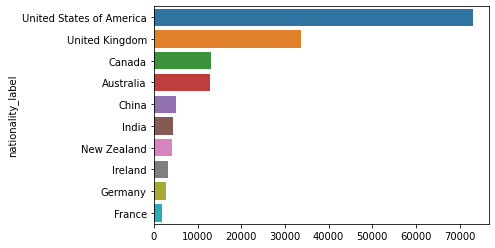

In [ ]:
# number of quotes by countries
countries = climate_countries_label.groupby(by='nationality_label').count().sort_values(by='quotation', ascending=False).quotation
sns.barplot(x=countries[:10].values, y=countries[:10].index)

It is time for a clear visualization of the nationality of our speakers, so we are providing an intersting map of the world for a clear vision! :)

In [ ]:
pip install pycountry

     |████████████████████████████████| 10.1 MB 8.5 MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746883 sha256=e2a8e7e51fb26dbfb618a727cd5a5f88bf7ef9201bb2900891cf34ba7d8b9329
  Stored in directory: /root/.cache/pip/wheels/57/e8/3f/120ccc1ff7541c108bc5d656e2a14c39da0d824653b62284c6
Successfully built pycountry


In [ ]:
pip install geopandas

     |████████████████████████████████| 1.0 MB 8.9 MB/s 
     |████████████████████████████████| 15.4 MB 70 kB/s 
     |████████████████████████████████| 6.3 MB 15.3 MB/s 


In [ ]:
pip install mapclassify

In [ ]:
import pycountry 
import geopandas

In [ ]:
# generate country code  based on country name 
# from https://melaniesoek0120.medium.com/data-visualization-how-to-plot-a-map-with-geopandas-in-python-73b10dcd4b4b
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE

In [ ]:
# add to the country dataframe all the infos about the countries for the world map
countries_df = pd.DataFrame(countries)
countries_df.reset_index(inplace=True)
countries_df.replace('United States of America', 'United States', inplace=True)
countries_df['CODE'] = alpha3code(countries_df.nationality_label)
countries_df = countries_df.drop(countries_df.index[countries_df['CODE'] == 'None'])
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.columns = ['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
countries_geo = pd.merge(world, countries_df,on='CODE')
countries_geo.sample(3)

,pop_est,continent,name,CODE,gdp_md_est,geometry,nationality_label,quotation
122,1221549,Asia,Cyprus,CYP,29260.0,"POLYGON ((32.73178 35.14003, 32.91957 35.08783...",Cyprus,33
64,39192111,Asia,Iraq,IRQ,596700.0,"POLYGON ((39.19547 32.16101, 38.79234 33.37869...",Iraq,6
112,4926330,Asia,Georgia,GEO,37270.0,"POLYGON ((39.95501 43.43500, 40.07696 43.55310...",Georgia,12


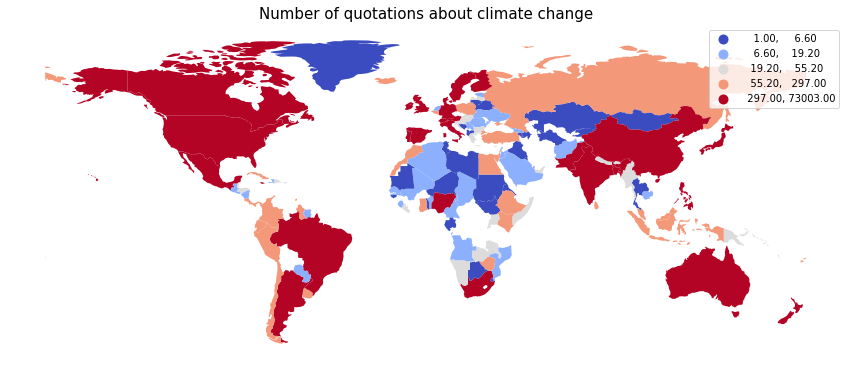

In [ ]:
# plot the number of quotations on the world map
countries_geo.plot(column='quotation', scheme="quantiles", figsize=(15, 20), legend=True, cmap='coolwarm')
plt.title('Number of quotations about climate change',fontsize=15)
plt.axis("off")
plt.show()

# Political parties

Political parties are an important part of our analysis, so in this section we are extracting all the information about them that we will merge with our data set containing quotes abogabout climate change. The idea is, also, to divide the political parties into left-wing and right-wing parties and try to perform a classification that will provide us with the information is there a difference on how left-wing and right-wing parties treat climate change.

In [ ]:
# add the labels of the parties
climate_wikidata_label = climate_countries_label.explode('party').merge(qids, left_on='party', right_on='QID')
climate_wikidata_label.drop(columns=['Description'], axis=1, inplace=True)
climate_wikidata_label.rename(columns={'Label': 'party_label', 'party': 'party_qid'}, inplace=True)

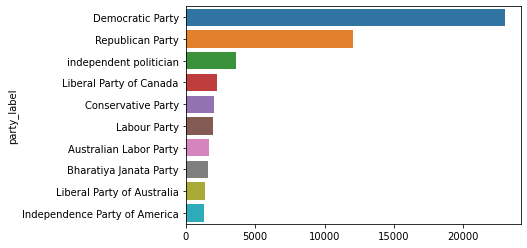

In [ ]:
# number of quotes by parties in the world
parties = climate_wikidata_label.groupby(by='party_label').count().sort_values(by='quotation', ascending=False).quotation
sns.barplot(x=parties[:10].values, y=parties[:10].index)

In [ ]:
# number of quotes by countries and parties in the world
parties_countries = climate_wikidata_label.groupby(by=['nationality_label', 'party_label']).count().sort_values(by='quotation', ascending=False).quotation
parties_countries_df = pd.DataFrame(parties_countries)
parties_countries_df.reset_index(inplace=True)
parties_countries_df.head()

,nationality_label,party_label,quotation
0,United States of America,Democratic Party,22679
1,United States of America,Republican Party,11626
2,United States of America,independent politician,2567
3,Canada,Liberal Party of Canada,2188
4,United Kingdom,Conservative Party,1781


Text(0, 0.5, 'political party')

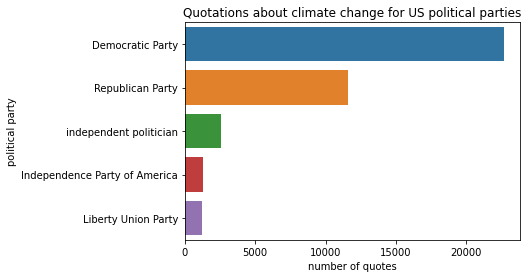

In [ ]:
# parties for the USA
US_data = parties_countries_df[parties_countries_df.nationality_label == 'United States of America']
# plt.figure(figsize=(10, 7))
plt.title("Quotations about climate change for US political parties")
sns.barplot(data=US_data[:5], x='quotation', y='party_label')
plt.xlabel("number of quotes")
plt.ylabel("political party")

In [ ]:
# all the parties for USA
US_data.party_label.unique()

array(['Democratic Party', 'Republican Party', 'independent politician',
       'Independence Party of America', 'Liberty Union Party',
       'Minnesota Democratic–Farmer–Labor Party',
       'California Democratic Party', 'Conservative Party',
       'Libertarian Party', 'Green Party of the United States',
       'Iowa Democratic Party',
       'North Dakota Democratic-Nonpartisan League Party',
       'Raza Unida Party', 'Republican Party of Minnesota',
       'California Republican Party', 'Conservative Party of Canada',
       'Reform Party of Canada', 'Canadian Alliance',
       'Saskatchewan Party', 'New Democratic Party',
       'Green Party of Aotearoa New Zealand', 'Working Families Party',
       'Democratic Party of Hawaii', 'Republican Party of Iowa',
       'Florida Democratic Party', 'North Dakota Republican Party',
       'Democratic Party of Oregon', 'Oregon Republican Party',
       'Conservative Party of New York State',
       'Vermont Progressive Party', 'Maine Dem

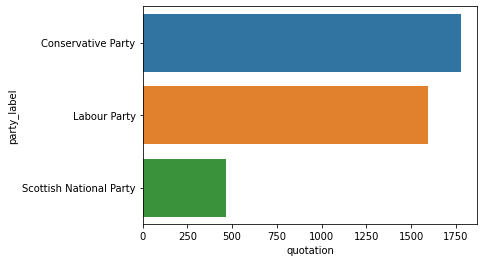

In [ ]:
# parties for the UK
UK_data = parties_countries_df[parties_countries_df.nationality_label == 'United Kingdom']
sns.barplot(data=UK_data[:3], x='quotation', y='party_label')

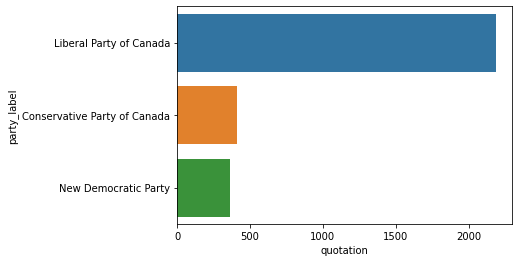

In [ ]:
# parties for Canada
canada_data = parties_countries_df[parties_countries_df.nationality_label == 'Canada']
sns.barplot(data=canada_data[:3], x='quotation', y='party_label')

In [ ]:
# all the parties for Germany
germany_data = parties_countries_df[parties_countries_df.nationality_label == 'Germany']
germany_data.party_label.unique()

array(['Christian Democratic Union', 'Social Democratic Party of Germany',
       'Democratic Awakening', "Alliance '90/The Greens",
       'Christian Social Union of Bavaria', 'Free Democratic Party',
       "Democratic Farmers' Party of Germany", 'Libertarian Party',
       'Republican Party', 'Communist League of West Germany',
       'Alternative for Germany', 'Freie Wähler',
       'Socialist Unity Party of Germany', 'Communist League',
       'The Greens', 'National Democratic Party of Germany',
       'Party of Democratic Socialism', 'New Forum', 'The Left',
       'International Marxist Group', 'Alliance 90', 'Democracy Now',
       'Free Voters of Bavaria', 'German Communist Party',
       'Liberal Party of Australia', 'Nashi', 'The Blue Party',
       'United Russia', 'non-attached'], dtype=object)

# Classifying with political parties

In this part we are creating a fasttext classifier that will try to distinguish between quotes made by speakers that belong to a certain group of political parties.

We chose Germany to be our example country.

## For Germany

In [ ]:
# extracting the quotes from Germany
germany_data = climate_wikidata_label[climate_wikidata_label.nationality_label == 'Germany']
germany_data.head(1)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,year,date_of_birth,nationality_qid,party_qid,nationality_label,party_label
36936,2016-05-23-048206,It is tough to hate a company that is reducing...,Peter Thiel,Q705525,2016-05-23 11:06:55,1,"[[Peter Thiel, 0.5003], [Jeff Immelt, 0.3813],...",[http://fortune.com/2016/05/23/ceo-daily-monda...,E,2016,[+1967-10-11T00:00:00Z],Q183,Q29468,Germany,Republican Party


In [ ]:
# defining a function for creating the groups of political parties
# the 'undefined' group refers to political parties for which we can not precisely say what group they belong to
def f(row):
    if row['party_label'] in ['Christian Democratic Union', 'Christian Social Union of Bavaria', 'Democratic Farmers\' Party of Germany', 'Republican Party', 'Libertarian Party', 'The Greens'] :
        val = 'right-center'
    elif row['party_label'] == 'Social Democratic Party of Germany' :
        val = 'left-center'
    else:
        val = 'undefined'
    return val

In [ ]:
# printing out the number of quotes
germany_data['party_wing_label'] = germany_data.apply(f, axis=1)
germany_data.shape

(746, 16)

In [ ]:
# printing out the difference in counts, we can observe a slight imbalance between the right and left center
germany_data.party_wing_label.value_counts()

right-center    321
undefined       274
left-center     151
Name: party_wing_label, dtype: int64

In [ ]:
# creating a dataset with just quotes and the party group label
germany_data_for_fasttext = germany_data[['quotation', 'party_wing_label']].copy()
germany_data_for_fasttext.head(3)

,quotation,party_wing_label
36936,It is tough to hate a company that is reducing...,right-center
36937,I'm not sure I'm an extreme skeptic of climate...,right-center
36938,I would say that I would be much more convince...,right-center


In [ ]:
# we need to create a .txt file since fasttext is working with that type of filw
germany_data_for_fasttext.to_csv('germany_quotes_party_wings.txt', sep='\t', index=False)

Include fasttext

In [ ]:
# downloading fasttext
! wget https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
! unzip v0.9.2.zip
%cd fastText-0.9.2
!make

--2021-12-10 13:39:16--  https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/v0.9.2 [following]
--2021-12-10 13:39:16--  https://codeload.github.com/facebookresearch/fastText/zip/v0.9.2
Resolving codeload.github.com (codeload.github.com)... 192.30.255.120
Connecting to codeload.github.com (codeload.github.com)|192.30.255.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘v0.9.2.zip’

v0.9.2.zip              [  <=>               ]   4.17M  14.1MB/s    in 0.3s    

2021-12-10 13:39:16 (14.1 MB/s) - ‘v0.9.2.zip’ saved [4369852]

Archive:  v0.9.2.zip
5b5943c118b0ec5fb9cd8d20587de2b2d3966dfe
   creating: fastText-0.9.2/
   creating: fastText-0.9.2/.circleci/
  inflating: fastTe

In [ ]:
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!pip install .

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.22 MiB | 21.59 MiB/s, done.
Resolving deltas: 100% (2417/2417), done.
/content/fastText-0.9.2/fastText
Processing /content/fastText-0.9.2/fastText
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Using cached pybind11-2.8.1-py2.py3-none-any.whl (208 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3119586 sha256=3122aa6cd4ec0484dfb78101500207c79018d87c22fc8cd977f8b9a3092e0e16
  Stored in directory: /tmp/pip-ephem-wheel-cache-uxbgx7

In [ ]:
# including our .txt file
data=pd.read_csv('/content/germany_quotes_party_wings.txt', sep='\t')

In [ ]:
# exploring the .txt file
print(data.head())
print(data.info())
print(data.shape)

                                           quotation party_wing_label
0  It is tough to hate a company that is reducing...     right-center
1  I'm not sure I'm an extreme skeptic of climate...     right-center
2  I would say that I would be much more convince...     right-center
3  I don't know whether I am an extreme skeptic o...     right-center
4  Even if climate change is quite as bad as peop...     right-center
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   quotation         746 non-null    object
 1   party_wing_label  746 non-null    object
dtypes: object(2)
memory usage: 11.8+ KB
None
(746, 2)


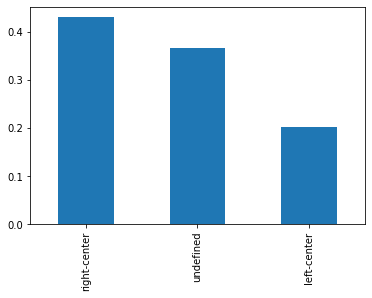

In [ ]:
# printing the distribution of the label variable
import matplotlib.pyplot as plt

data['party_wing_label'].value_counts(normalize=True).plot(kind='bar')
plt.show()

We convert the quotes to strings for easier manipulations

In [ ]:
# converting the quotes to strings
data['quotation']=data.apply(lambda x: str(x['quotation']), axis=1)

In [ ]:
# defining the short words
def short_words_eng():
    
    return {
        "ain't":"is not",
        "amn't":"am not",
        "aren't":"are not",
        "can't":"cannot",
        "'cause":"because",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "could've":"could have",
        "daren't":"dare not",
        "daresn't":"dare not",
        "dasn't":"dare not",
        "didn't":"did not",
        "doesn't":"does not",
        "don't":"do not",
        "e'er":"ever",
        "em":"them",
        "everyone's":"everyone is",
        "finna":"fixing to",
        "gimme":"give me",
        "gonna":"going to",
        "gon't":"go not",
        "gotta":"got to",
        "hadn't":"had not",
        "hasn't":"has not",
        "haven't":"have not",
        "he'd":"he would",
        "he'll":"he will",
        "he's":"he is",
        "he've":"he have",
        "how'd":"how would",
        "how'll":"how will",
        "how're":"how are",
        "how's":"how is",
        "I'd":"I would",
        "I'll":"I will",
        "I'm":"I am",
        "I'm'a":"I am about to",
        "I'm'o":"I am going to",
        "isn't":"is not",
        "it'd":"it would",
        "it'll":"it will",
        "it's":"it is",
        "I've":"I have",
        "kinda":"kind of",
        "let's":"let us",
        "mayn't":"may not",
        "may've":"may have",
        "mightn't":"might not",
        "might've":"might have",
        "mustn't":"must not",
        "mustn't've":"must not have",
        "must've":"must have",
        "needn't":"need not",
        "ne'er":"never",
        "o'":"of",
        "o'er":"over",
        "ol'":"old",
        "oughtn't":"ought not",
        "shalln't":"shall not",
        "shan't":"shall not",
        "she'd":"she would",
        "she'll":"she will",
        "she's":"she is",
        "shouldn't":"should not",
        "shouldn't've":"should not have",
        "should've":"should have",
        "somebody's":"somebody is",
        "someone's":"someone is",
        "something's":"something is",
        "that'd":"that would",
        "that'll":"that will",
        "that're":"that are",
        "that's":"that is",
        "there'd":"there would",
        "there'll":"there will",
        "there're":"there are",
        "there's":"there is",
        "these're":"these are",
        "they'd":"they would",
        "they'll":"they will",
        "they're":"they are",
        "they've":"they have",
        "this's":"this is",
        "those're":"those are",
        "'tis":"it is",
        "'twas":"it was",
        "wanna":"want to",
        "wasn't":"was not",
        "we'd":"we would",
        "we'd've":"we would have",
        "we'll":"we will",
        "we're":"we are",
        "weren't":"were not",
        "we've":"we have",
        "what'd":"what did",
        "what'll":"what will",
        "what're":"what are",
        "what's":"what is",
        "what've":"what have",
        "when's":"when is",
        "where'd":"where did",
        "where're":"where are",
        "where's":"where is",
        "where've":"where have",
        "which's":"which is",
        "who'd":"who would",
        "who'd've":"who would have",
        "who'll":"who will",
        "who're":"who are",
        "who's":"who is",
        "who've":"who have",
        "why'd":"why did",
        "why're":"why are",
        "why's":"why is",
        "won't":"will not",
        "wouldn't":"would not",
        "would've":"would have",
        "y'all":"you all",
        "you'd":"you would",
        "you'll":"you will",
        "you're":"you are",
        "you've":"you have",
        "Whatcha":"What are you",
        "luv":"love",
        "sux":"sucks"
        }


In [ ]:
# function for cleaning the quotes
def cleaning(quote):    
    

    quote = re.sub(r"(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", quote)
    quote = re.sub("(\w+:\/\/\S+)", " ", quote)
    quote = quote.lower()
    quote = quote.replace("’","'")
    quote = re.sub('[\s]+', ' ', quote)
    quote = quote.replace(":"," ")
    quote = quote.replace("\x92", "'")
    return quote

In [ ]:
# function for cleaning and replacing in the quotes
def cleaning_replace(quote):    
    
    SHORT=short_words_eng()
    words = quote.split()
    reformed = [SHORT[word] if word in SHORT else word for word in words]
    quote = " ".join(reformed) 
    return quote

In [ ]:
# the first text, only cleaned
data['text_one']= data.apply(lambda row:cleaning(row['quotation']),axis=1)

In [ ]:
# the second text, cleaned and replaced
data['text_two']=data.apply(lambda row:cleaning_replace(row['text_one']), axis=1)

In [ ]:
# we are working with three types of texts
# 1. uncleaned
# 2. cleaned
# 3. cleaned and replaced
data[30:35][['quotation','text_one','text_two']]

,quotation,text_one,text_two
30,"At the margin, this would probably be a lowest...","at the margin, this would probably be a lowest...","at the margin, this would probably be a lowest..."
31,Everyone is repeatedly surprised at how fast e...,everyone is repeatedly surprised at how fast e...,everyone is repeatedly surprised at how fast e...
32,The world in which we have to tackle climate c...,the world in which we have to tackle climate c...,the world in which we have to tackle climate c...
33,If you really want to reduce global warming......,if you really want to reduce global warming......,if you really want to reduce global warming......
34,This is one of the reasons why despite everyth...,this is one of the reasons why despite everyth...,this is one of the reasons why despite everyth...


In [ ]:
# downloading the augmenter
! pip install nlpaug
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

     |████████████████████████████████| 408 kB 7.6 MB/s 
     |████████████████████████████████| 11.3 MB 45.3 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.4 which is incompatible.


In [ ]:
# initiating of the augmenter
aug = naw.SynonymAug(aug_src='wordnet',aug_max=3)

Splitting the text onto train, validating and testing

In [ ]:
# import the train_test_split
from sklearn.model_selection import train_test_split

In [ ]:
# performing the train and test split
X_train_all, X_test, y_train_all, y_test = train_test_split(data[['quotation','text_one','text_two']], data['party_wing_label'], test_size=0.2,random_state=42)

In [ ]:
# extracting the validating set
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2,random_state=42)

In [ ]:
y_train_tf=y_train[:]

Using an uppersampling method

In [ ]:
# import load_model
from fasttext import load_model

In [ ]:
# writing into the three files
train_clean = open('data.train.clean','w')
val_clean = open('data.val.clean','w')
test_clean=open('data.test.clean','w')

In [ ]:
# extracting the clean quotes
X_train_clean=X_train['quotation']
X_val_clean=X_val['quotation']
X_test_clean=X_test['quotation']

In [ ]:
upper_num = X_train_clean.str.findall(r'[A-Z]').str.len()

In [ ]:
sum(upper_num)

1583

In [ ]:
# writing into the three files for all the three types texts
for x in X_train.index:
  print(f'__label__{y_train[x]} {X_train_clean[x]}', file=train_clean)
for x in X_val.index:
  print(f'__label__{y_val[x]} {X_val_clean[x]}', file=val_clean)
for x in X_test.index:
  print(f'__label__{y_test[x]} {X_test_clean[x]}', file=test_clean)

In [ ]:
# training ...
!/content/fastText-0.9.2/fasttext supervised -input data.train.clean -output model_data_clean  -epoch 100 

Read 0M words
Number of words:  2965
Number of labels: 3
Progress: 100.0% words/sec/thread:  438786 lr:  0.000000 avg.loss:  0.491962 ETA:   0h 0m 0s


In [ ]:
# obtaining the results
classifie_data_clean = load_model("/content/fastText-0.9.2/fastText/model_data_clean.bin") 

In [ ]:
# printing
results_data_val_clean=classifie_data_clean.test("/content/fastText-0.9.2/fastText/data.val.clean")
results_data_val_clean

(104, 0.4326923076923077, 0.4326923076923077)

For the text one cleaned data

In [ ]:
del classifie_data_clean

In [ ]:
train_one = open('data.train.one','w')
val_one = open('data.val.one','w')
test_one=open('data.test.one','w')

In [ ]:
X_train_one=X_train['text_one']
X_val_one=X_val['text_one']
X_test_one=X_test['text_one']

In [ ]:
for x in X_train.index:
  print(f'__label__{y_train[x]} {X_train_one[x]}', file=train_one)
for x in X_val.index:
  print(f'__label__{y_val[x]} {X_val_one[x]}', file=val_one)
for x in X_test.index:
  print(f'__label__{y_test[x]} {X_test_one[x]}', file=test_one)

In [ ]:
!/content/fastText-0.9.2/fasttext supervised -input data.train.one -output model_data_one  -epoch 100

Read 0M words
Number of words:  2791
Number of labels: 3
Progress: 100.0% words/sec/thread:  438501 lr:  0.000000 avg.loss:  0.460313 ETA:   0h 0m 0s


In [ ]:
classifie_data_one = load_model("/content/fastText-0.9.2/fastText/model_data_one.bin")

In [ ]:
results_data_val_one=classifie_data_one.test("/content/fastText-0.9.2/fastText/data.val.one")
results_data_val_one

(104, 0.41346153846153844, 0.41346153846153844)

For text two

In [ ]:
del classifie_data_one

In [ ]:
train_two = open('data.train.two','w')
val_two= open('data.val.two','w')
test_two=open('data.test.two','w')

In [ ]:
X_train_two=X_train['text_two']
X_val_two=X_val['text_two']
X_test_two=X_test['text_two']

In [ ]:
for x in X_train.index:
  print(f'__label__{y_train[x]} {X_train_two[x]}', file=train_two)
for x in X_val.index:
  print(f'__label__{y_val[x]} {X_val_two[x]}', file=val_two)
for x in X_test.index:
  print(f'__label__{y_test[x]} {X_test_two[x]}', file=test_two)

In [ ]:
!/content/fastText-0.9.2/fasttext supervised -input data.train.two -output model_data_two  -epoch 100 

Read 0M words
Number of words:  2771
Number of labels: 3
Progress: 100.0% words/sec/thread:  441046 lr:  0.000000 avg.loss:  0.508251 ETA:   0h 0m 0s


In [ ]:
classifie_data_two = load_model("/content/fastText-0.9.2/fastText/model_data_two.bin")

In [ ]:
results_data_val_two=classifie_data_two.test("/content/fastText-0.9.2/fastText/data.val.two")
results_data_val_two

(103, 0.4368932038834951, 0.4368932038834951)

Since the 'best' results are obtained with 'text_two' we are moving forward with that one

In [ ]:
del classifie_data_two

In [ ]:
# downloading wordnet
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# creating the space for augmented sentences
augmented_sentences=[]
augmented_sentences_labels=[]

In [ ]:
# creating the train, val, and test set
X_train=X_train['text_two']
X_val=X_val['text_two']
X_test=X_test['text_two']

In [ ]:
# augmenting the sentences
nltk.download('averaged_perceptron_tagger')
for i in X_train.index:
  if y_train[i]=='left-center':
    temps=aug.augment(X_train[i],n=2)
    for sent in temps:
      augmented_sentences.append(sent)
      augmented_sentences_labels.append('left-center')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
len(augmented_sentences)

190

In [ ]:
# performing the randomization
import random
random.seed(42)
fin_sentences=random.sample(augmented_sentences, int(len(augmented_sentences)/2))
fin_sentences_labels=random.sample(augmented_sentences_labels, len(fin_sentences))

In [ ]:
len(fin_sentences)

95

In [ ]:
# adding the augmented sentences
X_train=X_train.append(pd.Series(fin_sentences),ignore_index=True)
y_train=y_train.append(pd.Series(fin_sentences_labels),ignore_index=True)

print(X_train.shape)
print(y_train.shape)

(571,)
(571,)


In [ ]:
y_train=y_train.append(pd.Series(fin_sentences_labels),ignore_index=True)

Observe the balancing

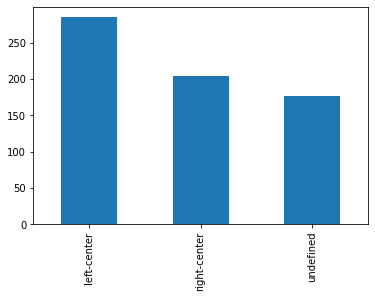

In [ ]:
# plotting to see the balancing
y_train.value_counts().plot(kind='bar')
plt.show()

In [ ]:
# extracting the tf datasets
X_train_tf=X_train[:]
X_val_tf=X_val[:]
X_test_tf=X_test[:]

In [ ]:
# downloading punkt and tokenizing
nltk.download('punkt')
X_train= X_train.apply(lambda row: nltk.word_tokenize(row))
X_val= X_val.apply(lambda row: nltk.word_tokenize(row))
X_test= X_test.apply(lambda row: nltk.word_tokenize(row))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
del aug

In [ ]:
# exploring the validation dataset
y_val.value_counts()

right-center    49
undefined       48
left-center     23
Name: party_wing_label, dtype: int64

In [ ]:
# creating three files for writing
train = open('data.train','w')
val = open('data.val','w')
test=open('data.test','w')

In [ ]:
# writing into the three files
for x in X_train.index:
  print(f'__label__{y_train[x]} {X_train[x]}', file=train)
for x in X_val.index:
  print(f'__label__{y_val[x]} {X_val[x]}', file=val)
for x in X_test.index:
  print(f'__label__{y_test[x]} {X_test[x]}', file=test)

In [ ]:
# training the model in 10 epochs, because of RAM ...
!/content/fastText-0.9.2/fasttext supervised -input data.train -output model_data  -epoch 10 -autotune-validation data.val -autotune-metric f1

Progress:   7.7% Trials:   49 Best score:  0.483333 ETA:   0h 4m36stcmalloc: large alloc 2040537088 bytes == 0x55f9615d2000 @  0x7f5314498887 0x55f91af10fed 0x55f91af1f72e 0x55f91af2750c 0x55f91aef322f 0x55f91af2ea84 0x55f91aee4887 0x7f5313535bf7 0x55f91aee4b4a
Progress:  12.7% Trials:   73 Best score:  0.483333 ETA:   0h 4m21stcmalloc: large alloc 1281818624 bytes == 0x55f9615d0000 @  0x7f5314498887 0x55f91af10fed 0x55f91af1f72e 0x55f91af2750c 0x55f91aef322f 0x55f91af2ea84 0x55f91aee4887 0x7f5313535bf7 0x55f91aee4b4a
Progress:  22.8% Trials:  141 Best score:  0.508333 ETA:   0h 3m51stcmalloc: large alloc 1410211840 bytes == 0x55f9615d0000 @  0x7f5314498887 0x55f91af10fed 0x55f91af1f72e 0x55f91af2750c 0x55f91aef322f 0x55f91af2ea84 0x55f91aee4887 0x7f5313535bf7 0x55f91aee4b4a
Progress:  28.5% Trials:  180 Best score:  0.508333 ETA:   0h 3m34stcmalloc: large alloc 3160825856 bytes == 0x55f9615d0000 @  0x7f5314498887 0x55f91af10fed 0x55f91af1f72e 0x55f91af2750c 0x55f91aef322f 0x55f91af2ea

In [ ]:
# extracting the results
classifie_data = load_model("/content/fastText-0.9.2/fastText/model_data.bin")  

In [ ]:
# printing the accuracy results on the validation set
results_data_val=classifie_data.test("/content/fastText-0.9.2/fastText/data.val")
results_data_val

(120, 0.48333333333333334, 0.48333333333333334)

In [ ]:
# printing the results on the test set
results_data=classifie_data.test("/content/fastText-0.9.2/fastText/data.test",threshold=0.5)
results_data

(132, 0.4074074074074074, 0.25)

In [ ]:
# printing the results of the other metrics
results_data_ev=classifie_data.test_label("/content/fastText-0.9.2/fastText/data.test")
results_data_ev

{'__label__left-center': {'f1score': 0.2916666666666667,
  'precision': 0.3333333333333333,
  'recall': 0.25925925925925924},
 '__label__right-center': {'f1score': 0.5228758169934641,
  'precision': 0.43478260869565216,
  'recall': 0.6557377049180327},
 '__label__undefined': {'f1score': 0.15873015873015872,
  'precision': 0.2631578947368421,
  'recall': 0.11363636363636363}}

# Age categories

Age categories analysis will help us determine is there a significant difference in the opinions of different age groups about climate change. By adding the age information to every speaker of a quote, we will try to summarize, compare, and observe the opinions that people of a certain age have about climate change.

In [ ]:
# to find the age category
def age_category(age):
  if age < 17:
    return '0-16'
  elif age < 31:
    return '17-30'
  elif age < 46:
    return '31-45'
  elif age < 66:
    return '46-65'
  else:
    return '66+'

In [ ]:
# create birth_year, age and age_category columns
climate_wikidata_ages = climate_wikidata_label.dropna(axis=0, subset=['date_of_birth'])
climate_wikidata_ages['birth_year'] = climate_wikidata_ages.date_of_birth.apply(lambda x: int(x[0][1:5]))
climate_wikidata_ages['age'] = climate_wikidata_ages['year'] - climate_wikidata_ages['birth_year']
climate_wikidata_ages['age_category'] = climate_wikidata_ages['age'].apply(age_category)
climate_wikidata_ages.sample(3)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,year,date_of_birth,nationality_qid,party_qid,nationality_label,party_label,birth_year,age,age_category
56649,2019-05-13-013248,Climate change featured merely as an afterthou...,Ska Keller,Q71528,2019-05-13 13:16:52,1,"[[Ska Keller, 0.9224], [None, 0.0673], [Bas Ei...",[https://www.theparliamentmagazine.eu/articles...,E,2019,[+1981-11-22T00:00:00Z],Q16957,Q49766,East Germany,Alliance '90/The Greens,1981,38,31-45
12315,2017-07-11-036425,"I don't want them, in 50 years, saying, `Grand...",Al Franken,Q319084,2017-07-11 17:20:14,1,"[[Al Franken, 0.5648], [None, 0.4352]]",[http://aplus.com/a/al-franken-david-letterman...,E,2017,[+1951-05-21T00:00:00Z],Q30,Q29552,United States of America,Democratic Party,1951,66,66+
64226,2017-11-23-088142,Using solar power to generate the energy requi...,Phil Goff,Q597909,2017-11-23 11:11:33,2,"[[Phil Goff, 0.8625], [None, 0.1018], [Simon M...",[http://auckland.scoop.co.nz/2017/11/anniversa...,E,2017,[+1953-06-22T00:00:00Z],Q664,Q1048192,New Zealand,New Zealand Labour Party,1953,64,46-65


Text(0, 0.5, 'age category')

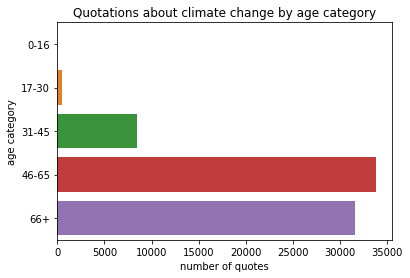

In [ ]:
# number of quotes by age category in the world
age_categories = climate_wikidata_ages.groupby(by='age_category').count().quotation
# plt.figure(figsize=(10, 7))
plt.title("Quotations about climate change by age category")
sns.barplot(x=age_categories[:10].values, y=age_categories[:10].index)
plt.xlabel("number of quotes")
plt.ylabel("age category")

# Sentiment analysis


In this part of our analysis, we will implement the afinn library with a goal of extracting the sentiment score of the quotes about climate change. The quotes will be placed in three different groups: positive, negative, and neutral. 

In [ ]:
#Install the library
! pip install afinn

     |████████████████████████████████| 52 kB 1.4 MB/s 
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53448 sha256=d4b86280db93b8f2b4d115b5a23c52e2ecbc17a2600f3a43a0fcfe84ee13d066
  Stored in directory: /root/.cache/pip/wheels/9d/16/3a/9f0953027434eab5dadf3f33ab3298fa95afa8292fcf7aba75
Successfully built afinn


In [ ]:
from afinn import Afinn
afn = Afinn()

In [ ]:
#We are iterating through the quotes, and the afinn calculates the sentiment score for every quote
sentiments = [afn.score(quote) for quote in climate_wikidata_label.quotation]
sentiments_for_ages = [afn.score(quote) for quote in climate_wikidata_ages.quotation]

In [ ]:
#Every quote will be enriched with its sentiment category
sentiment_category = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in sentiments]
sentiment_category_for_ages = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in sentiments_for_ages]

In [ ]:
#Adding the sentiment score and category to the dataframes with quotes
climate_wikidata_label['sentiment_score'] = sentiments
climate_wikidata_label['sentiment_category'] = sentiment_category
climate_wikidata_ages['sentiment_score'] = sentiments_for_ages
climate_wikidata_ages['sentiment_category'] = sentiment_category_for_ages
climate_wikidata_ages.head(3)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,year,date_of_birth,nationality_qid,party_qid,nationality_label,party_label,birth_year,age,age_category,sentiment_score,sentiment_category
0,2015-09-29-127038,We should work together to advance that goal. ...,Narendra Modi,Q1058,2015-09-29 04:23:24,1,"[[Narendra Modi, 0.7287], [None, 0.2713]]",[http://www.in.com/news/current-affairs/what-t...,E,2015,[+1950-09-17T00:00:00Z],Q668,Q10230,India,Bharatiya Janata Party,1950,65,46-65,8.0,positive
1,2015-11-06-019594,"During the summit, we will review the progress...",Narendra Modi,Q1058,2015-11-06 16:00:22,16,"[[Narendra Modi, 0.8165], [None, 0.1482], [Arv...",[http://www.newindianexpress.com/nation/PM-to-...,E,2015,[+1950-09-17T00:00:00Z],Q668,Q10230,India,Bharatiya Janata Party,1950,65,46-65,4.0,positive
2,2015-04-16-075231,tackling the issue of climate change is of vit...,Narendra Modi,Q1058,2015-04-16 14:40:19,1,"[[Narendra Modi, 0.4667], [None, 0.2763], [Fra...",[http://climate-l.iisd.org/news/india-france-e...,E,2015,[+1950-09-17T00:00:00Z],Q668,Q10230,India,Bharatiya Janata Party,1950,65,46-65,2.0,positive


In [ ]:
#Some example of positive quotes with high score (we took ones with max 20 as the ones with more than this are way too long and not representative)
pd.set_option('max_rows', 400)
pd.set_option('max_colwidth', 600)
climate_wikidata_label[(climate_wikidata_label['sentiment_category']=='positive') & (climate_wikidata_label['sentiment_score']>15) & (climate_wikidata_label['sentiment_score']<20)].head(5).loc[:, ['quotation', 'sentiment_category', 'sentiment_score']]

,quotation,sentiment_category,sentiment_score
159,"We discussed our ambitious national efforts and goals to increase the use of clean and renewable energy. We also agreed to further enhance our excellent and innovative partnership in this area. I asked him to lead international efforts in making renewable energy more accessible and affordable to the world. President and I expressed hope for a successful Paris Conference on climate change this year,",positive,19.0
332,"President Zuma and I also agreed on the need to work more closely on international issues and emerging global challenges. I thanked the President for South Africa's support to India's membership of the Nuclear Suppliers Group. We know that we can count on the active support of our friends, like South Africa. Climate change, and its impact on the world, is our shared concern. We agreed that a large scale effort and focus on renewable energy is needed to address this challenge. It was with this in mind that India had led the efforts to form an International Solar Alliance at COP 21 in Paris....",positive,16.0
347,"On Clean Energy and Climate Change, we are both committed to the 2015 Paris Agreement. Addressing climate change and promoting secure, affordable and sustainable supplies of energy are our shared priorities. We also reaffirmed our commitment to undertake mutual cooperation for reducing the cost of deployment of renewable energy. We will strengthen our cooperation with European Union in developing Smart Cities and upgrading urban infrastructure,",positive,17.0
538,"Clean Mobility powered by Clean Energy is our most powerful weapon in our fight against Climate Change. This means a pollution-free clean drive, leading to clean air and better living standards for our people. We should champion the idea of `clean kilometres,",positive,16.0
546,"Clean mobility powered by clean energy is our most powerful weapon in our fight against climate change. This means a pollution-free clean drive, leading to clean air and better living standards for our people. We should champion the idea of `clean kilometres' ,",positive,16.0


In [ ]:
#Some example of negative quotes with high score (we took ones with max 20 as the ones with more than this are way too long and not representative)
climate_wikidata_label[(climate_wikidata_label['sentiment_category']=='negative') & (climate_wikidata_label['sentiment_score']<-15) & (climate_wikidata_label['sentiment_score']>-25)].head(10).loc[:, ['quotation', 'sentiment_category', 'sentiment_score']]

,quotation,sentiment_category,sentiment_score
2316,"We're saying simply that this city -- which suffered so deeply after Hurricane Sandy -- has literally experienced billions and billions of dollars of damage as a result of climate change that these specific companies aided and abetted, and they should pay damages for that, very much the same way that tobacco companies were forced to pay damages for the horrible impact that they had knowingly on public health for so many years.",negative,-17.0
4275,"They have known, for a very long time, the executives of Exxon Mobil and other fossil fuel industries knew that the product that they were producing was causing climate change and in fact helping to destroy this planet... If you are producing a product and you don't know that it's causing harm, that's forgivable. But if you are like the tobacco industry -- we go before Congress, we swear that all of our research has shown that there is not a problem with tobacco causing cancer or heart disease. They lied. My father died because he smoked two packs of cigarettes a day. Millions of people ar...",negative,-21.0
4276,"They have known, for a very long time, the executives of Exxon Mobil and other fossil fuel industries knew that the product that they were producing was causing climate change and in fact helping to destroy this planet... If you are producing a product and you don't know that it's causing harm, that's forgivable. But if you are like the tobacco industry -- we go before Congress, we swear that all of our research has shown that there is not a problem with tobacco causing cancer or heart disease. They lied. My father died because he smoked two packs of cigarettes a day. Millions of people ar...",negative,-21.0
4421,"President Trump is dangerously, dangerously wrong. Climate change is an existential threat to the entire country and the entire world and we must be extraordinarily aggressive. I have seven grandchildren, and I'm going to be damned if I'm going to leave them a planet that is unhealthy and uninhabitable.",negative,-17.0
4422,"President Trump is dangerously, dangerously wrong. Climate change is an existential threat to the entire country and the entire world and we must be extraordinarily aggressive. I have seven grandchildren, and I'm going to be damned if I'm going to leave them a planet that is unhealthy and uninhabitable.",negative,-17.0
5202,"As such, Reverend Wright's comments were not only wrong but divisive, divisive at a time when we need unity; racially charged at a time when we need to come together to solve a set of monumental problems-two wars, a terrorist threat, a falling economy, a chronic health care crisis and potentially devastating climate change; problems that are neither black or white or Latino or Asian, but rather problems that confront us all.",negative,-18.0
5796,"If you actually believe that global warming is the biggest problem we face with terror all around the world, an $18 trillion dollar debt -- nine of which is yours -- no real allies left that trust us, riots in the streets, riots in our university campuses, race relations worse than I've seen since the 1960s, and a distrust of our fellow Americans unlike anything I have ever seen, you, sir, are either delusional or you're the dumbest son of a b **** on the planet. Which is it?",negative,-17.0
7351,"Too many Republicans wrongly blame immigrants for our problems, and they stand in the way of action on climate change and gun violence. Meanwhile, many Democrats wrongly blame the private sector for our problems, and they stand in the way of action on education reform and deficit reduction,",negative,-18.0
7352,"Too many Republicans wrongly blame immigrants for our problems, and they stand in the way of action on climate change and gun violence. Meanwhile, many Democrats wrongly blame the private sector for our problems, and they stand in the way of action on education reform and deficit reduction,",negative,-18.0
7799,"There is anothe

In [ ]:
#Describing the sentiment score
climate_wikidata_label['sentiment_score'].describe()

count    75704.000000
mean         0.510105
std          4.180400
min        -31.000000
25%         -2.000000
50%          0.000000
75%          2.000000
max         71.000000
Name: sentiment_score, dtype: float64

In [ ]:
#Describing the sentiment category
climate_wikidata_label['sentiment_category'].value_counts()

positive    32572
negative    26806
neutral     16326
Name: sentiment_category, dtype: int64

What is the evolution of sentiments concerning Climate Change through the years ? To put it all in a nutshell, how climate change skepticism has evolved until today ?  

Text(0.5, 1.0, 'POSITIVE quotations about global warming though time')

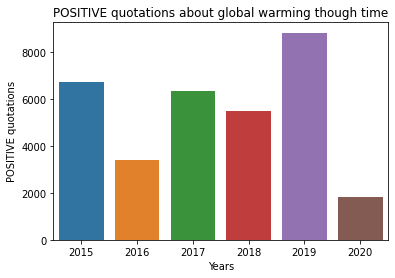

In [ ]:
# number of POSITIVE quotations about global warming through the years
count_years =  climate_wikidata_label[climate_wikidata_label['sentiment_category']=='positive'].groupby(by='year').count().quotation
sns.barplot(x=all_years, y=count_years)
plt.xlabel("Years")
plt.ylabel("POSITIVE quotations")
plt.title("POSITIVE quotations about global warming though time")

Text(0.5, 1.0, 'NEGATIVE quotations about global warming though time')

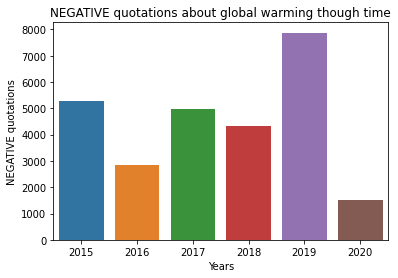

In [ ]:
# number of NEGATIVE quotations about global warming through the years
count_years =  climate_wikidata_label[climate_wikidata_label['sentiment_category']=='negative'].groupby(by='year').count().quotation
sns.barplot(x=all_years, y=count_years)
plt.xlabel("Years")
plt.ylabel("NEGATIVE quotations")
plt.title("NEGATIVE quotations about global warming though time")

Text(0.5, 1.0, 'NEUTRAL quotations about global warming though time')

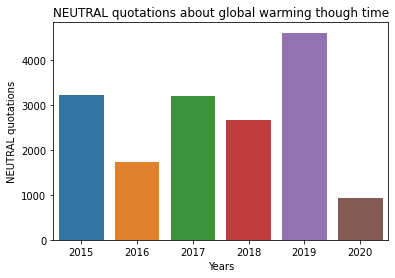

In [ ]:
# number of NEUTRAL quotations about global warming through the years
count_years =  climate_wikidata_label[climate_wikidata_label['sentiment_category']=='neutral'].groupby(by='year').count().quotation
sns.barplot(x=all_years, y=count_years)
plt.xlabel("Years")
plt.ylabel("NEUTRAL quotations")
plt.title("NEUTRAL quotations about global warming though time")

In [ ]:
#Calculate the ratio positive over negative

ratio = []
for year in all_years : 
  ratio.append(round((climate_wikidata_label[(climate_wikidata_label['year']==year) & (climate_wikidata_label['sentiment_category']=='positive')].count().quotation/climate_wikidata_label[(climate_wikidata_label['year']==year) & (climate_wikidata_label['sentiment_category']=='negative')].count().quotation)*100, 1))


[127.4, 119.0, 127.4, 126.4, 112.0, 121.6]

Text(0.5, 1.0, 'ratio of positive over negative quotation about global warming though the years since 2015')

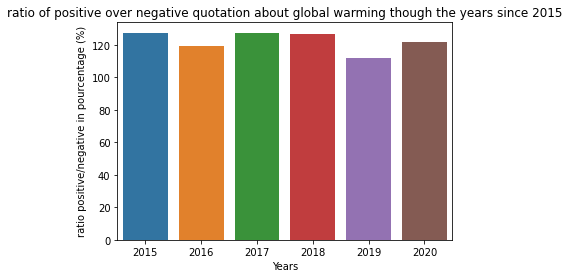

In [ ]:
sns.barplot(x=all_years, y=ratio)
plt.xlabel("Years")
plt.ylabel("ratio positive/negative in pourcentage (%)")
plt.title("ratio of positive over negative quotation about global warming though the years since 2015")

ANALYSIS :  It seems to go the wrong way around. Indeed, we would expect a positive increase and so a increase in the ratio. But here, it is only the case for the last year that is 2020. And, moreover, we lack quotation about climate change in 2020 so the analysis is screwed. The conclusion is that, from those data, we face an increase of climate skeptic... But is this really the case ? 

## Sentiments North America vs Europe

In [ ]:
#Countries we are using
climate_countries_label_europe = climate_wikidata_label[climate_wikidata_label.nationality_label.isin(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
   'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
   'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
   'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Slovenia', 'Croatia', 'Montenegro', 'North Macedonia', 'Kosovo', 'Romania', 'Bulgaria', 'Bosnia and Herzegovina', 'Greece', 'Serbia', 'Albania',
   'Belarus', 'Moldova', 'Ukraine', 'Switzerland'])]

In [ ]:
#Number of quotes
climate_countries_label_europe.sentiment_category.value_counts()

positive    2512
negative    1816
neutral     1110
Name: sentiment_category, dtype: int64

In [ ]:
#Describing sentiment score
climate_countries_label_europe.sentiment_score.describe()

count    5438.000000
mean        0.809121
std         4.228525
min       -31.000000
25%        -1.000000
50%         0.000000
75%         3.000000
max        30.000000
Name: sentiment_score, dtype: float64

In [ ]:
#North America
climate_countries_label_na = climate_wikidata_label[climate_wikidata_label.nationality_label.isin(['United States of America', 'Canada', 'Mexico'])]

In [ ]:
climate_countries_label_na.sentiment_category.value_counts()

positive    19548
negative    17877
neutral     10243
Name: sentiment_category, dtype: int64

In [ ]:
climate_countries_label_na.sentiment_score.describe()

count    47668.000000
mean         0.335550
std          4.212608
min        -31.000000
25%         -2.000000
50%          0.000000
75%          2.000000
max         71.000000
Name: sentiment_score, dtype: float64

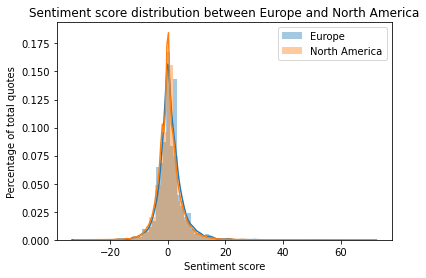

In [ ]:
#Distribution of sentiment score
ax = sns.distplot(climate_countries_label_europe['sentiment_score'], hist=True, label='Europe');
ax = sns.distplot(climate_countries_label_na['sentiment_score'], hist=True, label='North America')
ax.set(title='Sentiment score distribution between Europe and North America',xlabel='Sentiment score', ylabel='Percentage of total quotes')
plt.legend()
plt.show()

Text(0.5, 1.0, 'NEGATIVE quotations about global warming though time for Europe')

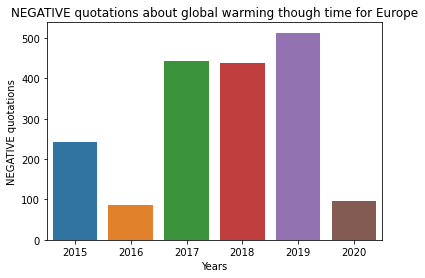

In [ ]:
# number of NEGATIVE quotations about global warming through the years FOR EUROPE
count_years =  climate_countries_label_europe[climate_countries_label_europe['sentiment_category']=='negative'].groupby(by='year').count().quotation
sns.barplot(x=all_years, y=count_years)
plt.xlabel("Years")
plt.ylabel("NEGATIVE quotations")
plt.title("NEGATIVE quotations about global warming though time for Europe")

Text(0.5, 1.0, 'NEGATIVE quotations about global warming though time')

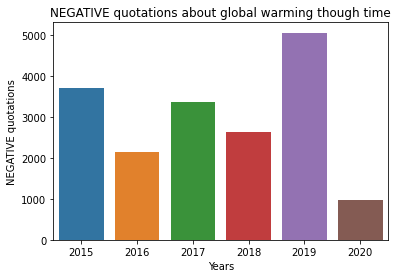

In [ ]:
# number of NEGATIVE quotations about global warming through the years FOR NORTH AMERICA
count_years =  climate_countries_label_na[climate_countries_label_na['sentiment_category']=='negative'].groupby(by='year').count().quotation
sns.barplot(x=all_years, y=count_years)
plt.xlabel("Years")
plt.ylabel("NEGATIVE quotations")
plt.title("NEGATIVE quotations about global warming though time")

Text(0.5, 1.0, 'POSITIVE quotations about global warming though age category')

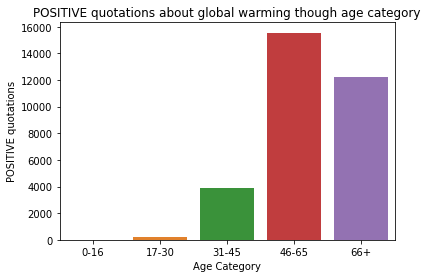

In [ ]:
#What about the age ? 
# number of POSITIVE quotations about global warming through age categories
all_ages_cat = ['0-16', '17-30', '31-45', '46-65', '66+']

count_ages =  climate_wikidata_ages[climate_wikidata_ages['sentiment_category']=='positive'].groupby(by='age_category').count().quotation
sns.barplot(x=all_ages_cat, y=count_ages)
plt.xlabel("Age Category")
plt.ylabel("POSITIVE quotations")
plt.title("POSITIVE quotations about global warming though age category")

Text(0.5, 1.0, 'NEGATIVE quotations about global warming though age category')

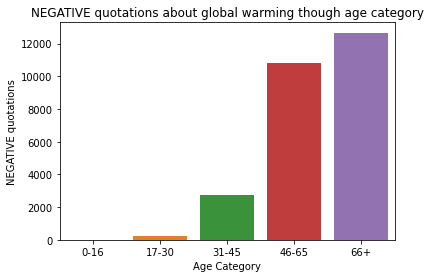

In [ ]:
#What about the age
# number of NEGATIVE quotations about global warming through age categories
all_ages_cat = ['0-16', '17-30', '31-45', '46-65', '66+']

count_ages =  climate_wikidata_ages[climate_wikidata_ages['sentiment_category']=='negative'].groupby(by='age_category').count().quotation
sns.barplot(x=all_ages_cat, y=count_ages)
plt.xlabel("Age Category")
plt.ylabel("NEGATIVE quotations")
plt.title("NEGATIVE quotations about global warming though age category")

Text(0.5, 1.0, 'NEUTRAL quotations about global warming though age category')

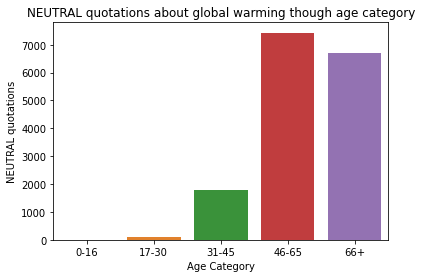

In [ ]:
#What about the age
# number of NEUTRAL quotations about global warming through age categories
count_ages =  climate_wikidata_ages[climate_wikidata_ages['sentiment_category']=='neutral'].groupby(by='age_category').count().quotation
sns.barplot(x=all_ages_cat, y=count_ages)
plt.xlabel("Age Category")
plt.ylabel("NEUTRAL quotations")
plt.title("NEUTRAL quotations about global warming though age category")

# Text summarization

In this part we are going to summarize the main thoughts about climate change by implementing summarization algorithms on the data and extracting the key information

For summarization algorithm we will give an explanation of the steps performed for one country/region. The rest are analogue.

##**First, we are using LexRank**

In [ ]:
# installing LexRank
! pip install lexrank
from lexrank import LexRank
from lexrank.mappings.stopwords import STOPWORDS

     |████████████████████████████████| 69 kB 3.4 MB/s 


For France

In [ ]:
# extracting quotes for France
df_france = climate_countries_label[climate_countries_label['nationality_label']=='France']
quotes = df_france['quotation'].tolist()

In [ ]:
# initiating LexRank
lxr = LexRank(quotes, stopwords=STOPWORDS['en'])

In [ ]:
# extracting the summary for LexRank
summary = lxr.get_summary(quotes, summary_size=2, threshold=.1)
print(summary)

["That's where we are in our history of our world. Climate change, global warming, is happening.", "It's an optimistic proposal to how we react to global warming and climate change,"]


For Germany

In [ ]:
df_germany = climate_countries_label[climate_countries_label['nationality_label']=='Germany']
quotes = df_germany['quotation'].tolist()

In [ ]:
lxr = LexRank(quotes, stopwords=STOPWORDS['en'])
summary = lxr.get_summary(quotes, summary_size=2, threshold=.1)
print(summary)

["California's aggressive climate change policies aren't going to change the occurrence (of global warming) throughout the world,", 'Its motivations are good, to tackle climate change and global warming [ these are the same? ].']


For India

In [ ]:
df_india = climate_countries_label[climate_countries_label['nationality_label']=='India']
quotes = df_india['quotation'].tolist()

In [ ]:
lxr = LexRank(quotes, stopwords=STOPWORDS['en'])
summary = lxr.get_summary(quotes, summary_size=2, threshold=.1)
print(summary)

['which is the cause of global warming and climate change.', 'Climate change, global warming... All these things are affecting us,']


##**Next, we are implementing Text Rank**

### For Sweden

In [ ]:
# climate_countries_label = pd.read_csv('climate_countries_label.csv')
climate_countries_sweden = climate_countries_label[climate_countries_label.nationality_label == 'Sweden']
climate_countries_sweden.head(1)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,year,date_of_birth,nationality_qid,party,nationality_label
164608,2015-04-17-085987,"This Montreal meeting will once again help connect Canadian scientists, engineers, entrepreneurs and policy makers with global leaders; and in turn will help drive economic progress while addressing issues such as climate change.",Roland Andersson,Q549367,2015-04-17 01:00:00,3,"[[Roland Andersson, 0.8], [None, 0.2]]","[http://www.pharmiweb.com/pressreleases/pressrel.asp?ROW_ID=113105, http://www.businesswire.com/news/home/20150417005631/en/Canada’s-Growing-Biobased-Economy-Showcased-2015-BIO, http://www.azocleantech.com/news.aspx?newsID=21758]",E,2015,[+1950-03-28T00:00:00Z],Q34,None,Sweden


Importing the necessary libraries for the task

In [ ]:
import nltk
nltk.download('punkt') # one time execution
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Tokenizing the sentences

In [ ]:
# sentence tokenizer
from nltk.tokenize import sent_tokenize
sentences = []
for s in climate_countries_sweden['quotation']:
  sentences.append(sent_tokenize(s))

sentences = [y for x in sentences for y in x]

Showing the first 5 sentences

In [ ]:
# Extracting the sentences that are tokenized
sentences[:5]

['This Montreal meeting will once again help connect Canadian scientists, engineers, entrepreneurs and policy makers with global leaders; and in turn will help drive economic progress while addressing issues such as climate change.',
 'This Montreal meeting will once again help connect Canadian scientists, engineers, entrepreneurs and policy makers with global leaders; and in turn will help drive economic progress while addressing issues such as climate change.',
 'This Montreal meeting will once again help connect Canadian scientists, engineers, entrepreneurs and policy makers with global leaders; and in turn will help drive economic progress while addressing issues such as climate change.',
 'It is very important that the World Conference on Disaster Risk Reduction which opens on March 14, should provide clear, action-oriented guidance to governments, local governments, the private sector and civil society in general on how best to tackle the underlying drivers of risk such as povert

Downloading the glove library for word embeddings

In [ ]:
# preparing the word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-12-08 17:24:03--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-12-08 17:24:03--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-08 17:24:04--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

From the word embeddings, we are extracting the word vectors

In [ ]:
# Extract word vectors
word_embeddings = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

In [ ]:
len(word_embeddings)

400000

Cleaning up the sentences, for every sentence we are removing the special characters and numbers since they do not have any special meaning for us
Also, we are transforming the sentences to lower case letters

In [ ]:
# clearning the sentences for every special sign
clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")

In [ ]:
# lower all the letters
clean_sentences = [s.lower() for s in clean_sentences]

We are removing the stopwords and using the nltk package for that

In [ ]:
# downloading the stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# importing the english language stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [ ]:
# a function for removing the stopwords
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

In [ ]:
# cleaning the sentences
clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]

Creating the sentence vectors

In [ ]:
# creating sentence vectors
sentence_vectors = []
for i in clean_sentences:
  if len(i) != 0:
    v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
  else:
    v = np.zeros((100,))
  sentence_vectors.append(v)

Creating the similarity matrix

In [ ]:
# similarity matrix
sim_mat = np.zeros([len(sentences), len(sentences)])
print(len(sentences))

1380


Calculating the cosine similarity

In [ ]:
# calculating the cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

for i in range(len(sentences)):
  for j in range(len(sentences)):
    if i != j:
      sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

We are using nx and the pagerank method to calculate the scores

In [ ]:
# creating a grapg
import networkx as nx

nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

Now, we are creating a series of ranked sentences

In [ ]:
# sorting the sentences
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

Extracting the top 10 sentences which represent our summary

In [ ]:
# Extract top 10 sentences as the summary
for i in range(10):
  print(ranked_sentences[i][1])

Climate change must now be regarded as one of the most significant challenges to people's health and well-being.
Climate change must now be regarded as one of the most significant challenges to people's health and well-being.
The UN has warned the world is not on track to meet climate change targets and it's clear the business community must scale up and speed efforts to help find solutions to the many environmental issues we face,
Our window of time to do this is very short, so I want to make sure we stay focused, and we do this in a way that benefits our entire community -- especially those most vulnerable to climate change.
And that climate change is much too important to ever give up on.
Knowledge of climate change and its causes has been around for a long time, so firstly, we also need to understand the type of reactions and everyday denials that explain why we don't take the greenhouse effect seriously-even when we see the consequences in front of our eyes.
Knowledge of climate c

### For the Balkans

In [ ]:
climate_countries_balkans = climate_countries_label[climate_countries_label.nationality_label.isin(['Slovenia', 'Croatia', 'Montenegro', 'North Macedonia', 'Kosovo', 'Romania', 'Bulgaria', 'Bosnia and Herzegovina', 'Greece', 'Serbia', 'Albania'])]
climate_countries_balkans.nationality_label.value_counts()

Bulgaria                  52
Greece                    41
Slovenia                  30
Croatia                   29
Romania                   16
Serbia                    12
Bosnia and Herzegovina     2
North Macedonia            1
Albania                    1
Name: nationality_label, dtype: int64

In [ ]:
from nltk.tokenize import sent_tokenize
sentences = []
for s in climate_countries_balkans['quotation']:
  sentences.append(sent_tokenize(s))

sentences = [y for x in sentences for y in x]

In [ ]:
clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")
clean_sentences = [s.lower() for s in clean_sentences]

clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]

In [ ]:
sentence_vectors = []
for i in clean_sentences:
  if len(i) != 0:
    v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
  else:
    v = np.zeros((100,))
  sentence_vectors.append(v)

In [ ]:
sim_mat = np.zeros([len(sentences), len(sentences)])
print(len(sentences))

353


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(len(sentences)):
  for j in range(len(sentences)):
    if i != j:
      sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

In [ ]:
import networkx as nx

nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

In [ ]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

In [ ]:
# Extract top 10 sentences as the summary
for i in range(10):
  print(ranked_sentences[i][1])

The idea is that, by doing a modest action, anyone could take part in solving the global problem of climate change.
Today we are moving to address EU concerns in the area of migration, make sure that consumers are better protected when they choose insurance products, and deliver on the EU's commitment to fight climate change and improve air quality.
This is not only good news for households and companies, but it's also an important groundwork in our fight against climate change.
If climate change is particularly bad for poor countries, that means climate change would make elimination of poverty extremely difficult,
The signing of these two programmes marks another step in the efforts of addressing the challenges of sustainable development and adapting to the effects of climate change, which affect all Pacific Island Countries.
This is a historic year for the new sustainable development agenda and the climate change negotiations -- these are intertwined and we must get both right,
Today

### For Eastern Europe

In [ ]:
climate_countries_eastern = climate_countries_label[climate_countries_label.nationality_label.isin(['Russia', 'Poland', 'Slovakia', 'Czech Republic', 'Belarus', 'Moldova', 'Ukraine', 'Hungary'])]
climate_countries_eastern.nationality_label.value_counts()

Russia            198
Poland             79
Slovakia           51
Hungary            45
Czech Republic     19
Ukraine            17
Belarus             5
Moldova             1
Name: nationality_label, dtype: int64

In [ ]:
from nltk.tokenize import sent_tokenize
sentences = []
for s in climate_countries_eastern['quotation']:
  sentences.append(sent_tokenize(s))

sentences = [y for x in sentences for y in x]

In [ ]:
clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")
clean_sentences = [s.lower() for s in clean_sentences]
clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]

In [ ]:
sentence_vectors = []
for i in clean_sentences:
  if len(i) != 0:
    v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
  else:
    v = np.zeros((100,))
  sentence_vectors.append(v)

In [ ]:
sim_mat = np.zeros([len(sentences), len(sentences)])
print(len(sentences))

679


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(len(sentences)):
  for j in range(len(sentences)):
    if i != j:
      sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

In [ ]:
import networkx as nx

nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

In [ ]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

In [ ]:
# Extract top 10 sentences as the summary
for i in range(10):
  print(ranked_sentences[i][1])

Never before has there been such a dire need for the open flow of targeted information between research and academia, on the one hand, and government and society, on the other, to ensure that ocean knowledge is bringing new solutions and technology to address the major challenges of our time: climate change, the ocean's declining health with its subsequent impact on human well-being and ability to sustain growing human population and blue economy.
International cooperation and climate changes taking place on the planet Earth require coordination among all professionals, as well as a comprehensive study of problems and development of proposals that would take into account the characteristics of all the regions and that would be effective at the lowest possible cost,
Russia's authorities agree that the global climate change in a real problem, including for our country,
Our ability to personally address the issue of climate change will determine the quality of life for all people on the p

### For the Baltics

In [ ]:
climate_countries_baltics = climate_countries_label[climate_countries_label.nationality_label.isin(['Sweden', 'Finland', 'Latvia', 'Lithuania', 'Estonia'])]
climate_countries_baltics.nationality_label.value_counts()

Sweden       690
Finland      337
Latvia        26
Estonia       14
Lithuania      6
Name: nationality_label, dtype: int64

In [ ]:
from nltk.tokenize import sent_tokenize
sentences = []
for s in climate_countries_baltics['quotation']:
  sentences.append(sent_tokenize(s))

sentences = [y for x in sentences for y in x]

In [ ]:
clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")
clean_sentences = [s.lower() for s in clean_sentences]
clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]

In [ ]:
sentence_vectors = []
for i in clean_sentences:
  if len(i) != 0:
    v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
  else:
    v = np.zeros((100,))
  sentence_vectors.append(v)

In [ ]:
sim_mat = np.zeros([len(sentences), len(sentences)])
print(len(sentences))

2180


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(len(sentences)):
  for j in range(len(sentences)):
    if i != j:
      sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

In [ ]:
import networkx as nx

nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

In [ ]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

In [ ]:
# Extract top 10 sentences as the summary
for i in range(10):
  print(ranked_sentences[i][1])

The rapidly growing demands to improve sustainability and saving the environment are opportunities for Northeastern students to become a leading pioneer with realistic answers on how to reduce Global Warming and climate change in the next three to five years, rather than a seemingly unsolvable problem at this time.
Climate change must now be regarded as one of the most significant challenges to people's health and well-being.
Climate change must now be regarded as one of the most significant challenges to people's health and well-being.
It is an undeniable fact that NFCS will play a significant role for the government when it comes to issues of planning and enabling the country get prepared to withstand disasters emanating from climate changes,
The UN has warned the world is not on track to meet climate change targets and it's clear the business community must scale up and speed efforts to help find solutions to the many environmental issues we face,
Now we are taking yet another step 

### For island countries

In [ ]:
climate_countries_islands = climate_countries_label[climate_countries_label.nationality_label.isin(['Maldives', 'Jamaica', 'Cuba', 'Dominican Republic', 'The Bahamas', 'Barbados', 'Mauritius', 'Tuvalu', 'Madagascar', 'Sri Lanka', 'Indonesia', 'Haiti', 'Seychelles', 'Iceland'])]
climate_countries_islands.nationality_label.value_counts()

Jamaica               479
Sri Lanka             147
Cuba                  116
Indonesia             105
Iceland                69
Tuvalu                 68
Barbados               65
The Bahamas            59
Seychelles             44
Dominican Republic     38
Maldives               24
Haiti                   7
Mauritius               4
Name: nationality_label, dtype: int64

In [ ]:
from nltk.tokenize import sent_tokenize
sentences = []
for s in climate_countries_islands['quotation']:
  sentences.append(sent_tokenize(s))

sentences = [y for x in sentences for y in x]

In [ ]:
clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")
clean_sentences = [s.lower() for s in clean_sentences]
clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]

In [ ]:
sentence_vectors = []
for i in clean_sentences:
  if len(i) != 0:
    v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
  else:
    v = np.zeros((100,))
  sentence_vectors.append(v)

In [ ]:
sim_mat = np.zeros([len(sentences), len(sentences)])
print(len(sentences))

2118


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(len(sentences)):
  for j in range(len(sentences)):
    if i != j:
      sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

In [ ]:
import networkx as nx

nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

In [ ]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

In [ ]:
# Extract top 10 sentences as the summary
for i in range(10):
  print(ranked_sentences[i][1])

There is greater understanding as a result of the Climate Action Summit amongst world leaders... but even though we have the agreement and we have COP21, I don't think we are where we should be today if we are serious as a global community to avoid the foretold effects of climate change, particularly Small Island Developing States,
What is clear to many of us though is that meeting the Sustainable Development Goals and the goal of leaving no one behind will become increasingly costly, more challenging and likely not met unless measures are taken to reduce the vulnerabilities and build the resilience of Small island Developing States to the climate change impacts which continue to set us back
This project is an example for the country of the positive work First Nations are doing right now to address climate change in a way that benefits their citizens, the economy and the environment.
One of the strongest benefits of being in the EU has been the chance to work together on the big enviro

### For USA Republican party younger than 50 years

In [ ]:
climate_wikidata_ages.head(1)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,year,date_of_birth,nationality_qid,party_qid,nationality_label,party_label,birth_year,age,age_category
0,2015-09-29-127038,We should work together to advance that goal. ...,Narendra Modi,Q1058,2015-09-29 04:23:24,1,"[[Narendra Modi, 0.7287], [None, 0.2713]]",[http://www.in.com/news/current-affairs/what-t...,E,2015,[+1950-09-17T00:00:00Z],Q668,Q10230,India,Bharatiya Janata Party,1950,65,46-65


In [ ]:
climate_wikidata_ages_USA = climate_wikidata_ages[climate_wikidata_ages.nationality_label == 'United States of America']
climate_wikidata_ages_USA = climate_wikidata_ages_USA[climate_wikidata_ages_USA.party_label == 'Republican Party']
climate_wikidata_ages_USA = climate_wikidata_ages_USA[climate_wikidata_ages_USA.age < 50]
climate_wikidata_ages_USA.shape

(1695, 18)

In [ ]:
from nltk.tokenize import sent_tokenize
sentences = []
for s in climate_wikidata_ages_USA['quotation']:
  sentences.append(sent_tokenize(s))

sentences = [y for x in sentences for y in x]

In [ ]:
sentences[:5]

['I acknowledge that global warming may in fact be a significant problem for mankind,',
 "I'd leave it to the scientists to decide how much [ human activity contributes to climate change ], what it means, and what the consequences are,",
 'leave it to the scientists to decide how much [ human activity contributes to climate change ], what it means, and what the consequences are.',
 'A lecture on climate change would do nothing to improve upon what we are already doing,',
 'If they attack me for sharing my faith, they will do the same to you.']

In [ ]:
clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")

In [ ]:
clean_sentences = [s.lower() for s in clean_sentences]

In [ ]:
clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]

In [ ]:
sentence_vectors = []
for i in clean_sentences:
  if len(i) != 0:
    v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
  else:
    v = np.zeros((100,))
  sentence_vectors.append(v)

In [ ]:
sim_mat = np.zeros([len(sentences), len(sentences)])
print(len(sentences))

3008


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(len(sentences)):
  for j in range(len(sentences)):
    if i != j:
      sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

In [ ]:
import networkx as nx

nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

In [ ]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

In [ ]:
# Extract top 10 sentences as the summary
for i in range(10):
  print(ranked_sentences[i][1])

What I said was that humans are not responsible for climate change in the way that some of these people out there are trying to make us believe for the following reason: I believe the climate is changing because there has never been a moment when the climate is not changing.
What I said was that humans are not responsible for climate change in the way that some of these people out there are trying to make us believe for the following reason: I believe the climate is changing because there has never been a moment when the climate is not changing.
What I said is, humans are not responsible for climate change in the way some of these people out there are trying to make us believe, for the following reason: I believe that climate is changing because there's never been a moment where the climate is not changing.
Humans are not responsible for climate change in the way some of these people out there are trying to make us believe, for the following reason: I believe the climate is changing be

### For USA Democratic party younger than 45 years

In [ ]:
climate_wikidata_ages_USA = climate_wikidata_ages[climate_wikidata_ages.nationality_label == 'United States of America']
climate_wikidata_ages_USA = climate_wikidata_ages_USA[climate_wikidata_ages_USA.party_label == 'Democratic Party']
climate_wikidata_ages_USA = climate_wikidata_ages_USA[climate_wikidata_ages_USA.age < 45]
climate_wikidata_ages_USA.shape

(2073, 18)

In [ ]:
from nltk.tokenize import sent_tokenize
sentences = []
for s in climate_wikidata_ages_USA['quotation']:
  sentences.append(sent_tokenize(s))

sentences = [y for x in sentences for y in x]

In [ ]:
clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")

In [ ]:
clean_sentences = [s.lower() for s in clean_sentences]

In [ ]:
clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]

In [ ]:
sentence_vectors = []
for i in clean_sentences:
  if len(i) != 0:
    v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
  else:
    v = np.zeros((100,))
  sentence_vectors.append(v)

In [ ]:
sim_mat = np.zeros([len(sentences), len(sentences)])
print(len(sentences))

3355


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(len(sentences)):
  for j in range(len(sentences)):
    if i != j:
      sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

In [ ]:
import networkx as nx

nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

In [ ]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

In [ ]:
# Extract top 10 sentences as the summary
for i in range(10):
  print(ranked_sentences[i][1])

We've got to take a serious look at all state levels and to make plans for the threat of climate change and human contributions to our climate crisis,
The purpose of the Green New Deal is to shake people up and say climate change is a serious crisis, Congress needs to act, and it needs to be doing so in a way that is job generating and helps communities left behind,
Even if we became extremely aggressive and forward-thinking in terms of our energy consumption we would still experience the worst effects of climate change if the rest of the world didn't join us.
For too long, our nation has failed to take action on climate change, putting the future of our people and our planet in danger.
For too long, our nation has failed to take action on climate change, putting the future of our people and our planet in danger,
This (partnership) is an example of how the administration can continue to advance what we consider to be and what the world considers to be a top priority, which is dealing w

### For people younger than 32 years

In [ ]:
# climate_countries_label = pd.read_csv('climate_countries_label.csv')
climate_countries_young = climate_wikidata_ages[climate_wikidata_ages.age <= 32]
climate_countries_young.head(1)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,year,date_of_birth,nationality_qid,party_qid,nationality_label,party_label,birth_year,age,age_category
1337,2016-05-13-025267,Global warming has become a worldwide phenomen...,Vinod Chamoli,Q28967710,2016-05-13 13:59:34,1,"[[Vinod Chamoli, 0.9771], [None, 0.0229]]",[http://timesofindia.indiatimes.com/home/envir...,E,2016,[+2000-00-00T00:00:00Z],Q668,Q10230,India,Bharatiya Janata Party,2000,16,0-16


In [ ]:
from nltk.tokenize import sent_tokenize
sentences = []
for s in climate_countries_young['quotation']:
  sentences.append(sent_tokenize(s))

sentences = [y for x in sentences for y in x]

In [ ]:
clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")
clean_sentences = [s.lower() for s in clean_sentences]
clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]

In [ ]:
sentence_vectors = []
for i in clean_sentences:
  if len(i) != 0:
    v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
  else:
    v = np.zeros((100,))
  sentence_vectors.append(v)

In [ ]:
sim_mat = np.zeros([len(sentences), len(sentences)])
print(len(sentences))

1248


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(len(sentences)):
  for j in range(len(sentences)):
    if i != j:
      sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

In [ ]:
import networkx as nx

nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

In [ ]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

In [ ]:
# Extract top 10 sentences as the summary
for i in range(10):
  print(ranked_sentences[i][1])

The actual problem is that since it's so politically toxic right now to say,' I don't believe in climate change,' as they've been doing for 10 years, now all of a sudden they're changing their position on a dime, and they're saying, `Oh, well, I believe in climate change, but I think that we need to have solutions on a 50-or 100-year time scale,' which is not that much different than denying the severity of the actual issue at hand,
the best thing we can do is be as supportive of climate policy, and to prioritize it, like if you can make climate change one of your top three voting issues, that's a huge thing you can do, but also if you change your personal consumption, that can do a lot as well.
People are ready to make climate change and the environment a far larger, far more important priority in terms of the kinds of things the government should be taking care of,
We only have a decade left to take action before climate change becomes irreversible, so it is encouraging that so many 

### People older than 80 years

In [ ]:
climate_countries_elder = climate_wikidata_ages[climate_wikidata_ages.age > 80]
climate_countries_elder.head(1)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,year,date_of_birth,nationality_qid,party_qid,nationality_label,party_label,birth_year,age,age_category
1132,2015-12-24-038641,Khulna needed a sustainable water supply syste...,Kamaluddin Ahmed,Q13116273,2015-12-24 08:39:17,1,"[[Kamaluddin Ahmed, 0.578], [Mohammad Abdullah...",[http://bdnews24.com/economy/2015/12/24/donors...,E,2015,[+1930-08-15T00:00:00Z],Q668,Q10230,India,Bharatiya Janata Party,1930,85,66+


In [ ]:
from nltk.tokenize import sent_tokenize
sentences = []
for s in climate_countries_elder['quotation']:
  sentences.append(sent_tokenize(s))

sentences = [y for x in sentences for y in x]

In [ ]:
clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")
clean_sentences = [s.lower() for s in clean_sentences]
clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]

In [ ]:
sentence_vectors = []
for i in clean_sentences:
  if len(i) != 0:
    v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
  else:
    v = np.zeros((100,))
  sentence_vectors.append(v)

In [ ]:
sim_mat = np.zeros([len(sentences), len(sentences)])
print(len(sentences))

3428


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(len(sentences)):
  for j in range(len(sentences)):
    if i != j:
      sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

In [ ]:
import networkx as nx

nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

In [ ]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

In [ ]:
# Extract top 10 sentences as the summary
for i in range(10):
  print(ranked_sentences[i][1])

For us to be a modern company, we have to be moving sort of at the same rate as changes in society, so I think that energy overall, and climate change specifically and mitigating our impacts to climate, that's become a big focus in the last three to five years with Goldcorp.
We stand in solidarity with those most affected by climate change -- often the most poor and vulnerable -- and call for the next Government to urgently stop contributing to climate change, and play their part in creating a just world for future generations.
I think in some ways the non-scientific message from this is that climate change, or climate sensitivity, is large enough to need action, but not so large that it's too late to do anything,
Climate change is undeniably real -- one just needs to review the sheer number of natural disasters Americans have experienced in the last month to understand how the decision to end the Clean Power Plan will put Americans' health, well-being, and security at further risk.
Fi

##**Finally, we are summarizing with the Luhn Summarizer**

In [ ]:
# preparing all the libraries for the Luhn Summarizer
! pip install sumy
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer 
from sumy.summarizers.luhn import LuhnSummarizer
import nltk
nltk.download('punkt')

     |████████████████████████████████| 87 kB 6.4 MB/s 
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21711 sha256=ef1dd2849e553b0015a4a7c788f6c20a05ba33f824f38ee4e561771759411a31
  Stored in directory: /root/.cache/pip/wheels/d4/bf/51/81d27ad638e1a6dca4f362ecc33d1e2c764b8ea7ec751b8fc1
Successfully built breadability
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

  For Germany

In [ ]:
# Extracting quotes about climate change from Germnay and initiating the LuhnSummarizer
climate_countries_label[climate_countries_label['nationality_label']=='Germany'].quotation.to_csv(r'germany.txt', header=None, index=None, sep=' ', mode='a')
file = "/content/germany.txt" 
parser = PlaintextParser.from_file(file, Tokenizer("english"))
summarizer_luhn = LuhnSummarizer()

In [ ]:
# The Luhn summarizer will summarize the document 
summary = summarizer_luhn(parser.document, 1) 

In [ ]:
# Printing the suumary of the document
for sentence in summary:
    print(sentence)

Yaaaay," "Despite all options for adaptation, the most important goal of the federal government is to altogether reduce the climate change and its effects" "Agriculture is a key factor for the sustainability of rural areas, the responsibility for food security and its potential to offer climate change solutions is enormous," "Despite all options for adaptation, the most important goal of the federal government is to altogether reduce the climate change and its effects" "Agriculture is a key factor for the sustainability of rural areas, the responsibility for food security and its potential to offer climate change solutions is enormous," "Despite all options for adaptation, the most important goal of the federal government is to altogether reduce the climate change and its effects" "Agriculture is a key factor for the sustainability of rural areas, the responsibility for food security and its potential to offer climate change solutions is enormous," "Despite all options for adaptation, 

For France

In [ ]:
climate_countries_label[climate_countries_label['nationality_label']=='France'].quotation.to_csv(r'france.txt', header=None, index=None, sep=' ', mode='a')
file = "/content/france.txt" 
parser = PlaintextParser.from_file(file, Tokenizer("english"))
summarizer_luhn = LuhnSummarizer()

In [ ]:
summary = summarizer_luhn(parser.document, 1) 
for sentence in summary:
    print(sentence)

I am honoured to co-author the preface with him," "the U.S. leadership and commitment to addressing the challenges presented by climate change," "We're here together to talk about economy and also to talk about climate change because both goals cannot be dealt separately," "As we meet in the Philippines, where people have endured an unprecedented series of extreme weather events in the last few years, we are reminded that while the developing countries have contributed least to climate change, they are the ones that suffer the most from climate change impacts," "My responsibility this coming December will be for us all to reach an agreement to combat climate change and ensure that life on our planet lasts for a very long time," "Anyone who thought the path to COP 21 would be paved with a signed agreement, an immediate reversal of climate change and laurel wreaths for us is going to be disappointed," "The Paris accord must send a clear signal for the world to engage in a transition towa

For Australia

In [ ]:
climate_countries_label[climate_countries_label['nationality_label']=='Australia'].quotation.to_csv(r'australia.txt', header=None, index=None, sep=' ', mode='a')
file = "/content/australia.txt" 
parser = PlaintextParser.from_file(file, Tokenizer("english"))
summarizer_luhn = LuhnSummarizer()

In [ ]:
summary = summarizer_luhn(parser.document, 1) 
for sentence in summary:
    print(sentence)

"But Greg Hunt and Malcolm Turnbull know their policy isn't the right policy and don't want that confirmed by the Climate Change Authority," "Malcolm Turnbull wants to duck a debate about renewable energy and climate change," "What we don't need is a government that won't act on climate change and won't allocate any new funds to protect the Reef," "regularly rails against our policies to expand renewable energy, so I'm not surprised that he is again campaigning against our Climate Change Action Plan" "I think it's definitely worth raising, and if it's applied appropriately I think it'll help to ensure we don't fund the stuff that's contrary to our climate change targets," "Really what has happened over the last ten years is that there has been a concerted attempt by parts of the Liberal Party and a number of groups in the media to stymie any action on climate change," "At the same time, the science is getting clearer and the impacts of climate change are starting to unfold before our e

For USA

In [ ]:
climate_countries_label[climate_countries_label['nationality_label']=='United States of America'].quotation.to_csv(r'usa.txt', header=None, index=None, sep=' ', mode='a')
file = "/content/usa.txt" 
parser = PlaintextParser.from_file(file, Tokenizer("english"))
summarizer_luhn = LuhnSummarizer()

In [ ]:
summary = summarizer_luhn(parser.document, 1) 
for sentence in summary:
    print(sentence)

These changes in distribution help identify species that may be in trouble and allow for the development of management programs to help address those declines," "We agree with the consensus of scientific experts who note that without drastic action from everyone -- governments, companies and all of us as individuals -- adapting to the impact of climate change in the future will be far more difficult and costly, taking a toll on our supply chains, our business, and more importantly, the lives of everyone involved," "We agree with the consensus of scientific experts who note that without drastic action from everyone -- governments, companies, and all of us as individuals -- adapting to the impact of climate change in the future will be far more difficult and costly," "We agree with the consensus of scientific experts who note that without drastic action from everyone -- governments, companies and all of us as individuals -- adapting to the impact of climate change in the future will be f

For Republican party - USA

In [ ]:
climate_wikidata_ages_USA = climate_wikidata_ages[climate_wikidata_ages.nationality_label == 'United States of America']
climate_wikidata_ages_USA[climate_wikidata_ages_USA['party_label']=='Republican Party'].quotation.to_csv(r'usa_republican.txt', header=None, index=None, sep=' ', mode='a')
file = "/content/usa_republican.txt" 
parser = PlaintextParser.from_file(file, Tokenizer("english"))
summarizer_luhn = LuhnSummarizer()

In [ ]:
summary = summarizer_luhn(parser.document, 1) 
for sentence in summary:
    print(sentence)

For Democratic party - USA

In [ ]:
climate_wikidata_ages_USA = climate_wikidata_ages[climate_wikidata_ages.nationality_label == 'United States of America']
climate_wikidata_ages_USA[climate_wikidata_ages_USA['party_label']=='Democratic Party'].quotation.to_csv(r'usa_democratic.txt', header=None, index=None, sep=' ', mode='a')
file = "/content/usa_democratic.txt" 
parser = PlaintextParser.from_file(file, Tokenizer("english"))
summarizer_luhn = LuhnSummarizer()

In [ ]:
summary = summarizer_luhn(parser.document, 1) 
for sentence in summary:
    print(sentence)

"Well I think it's completely ridiculous, but I think it's compelling to combine the biggest, as they like to call them existential threats -- terrorism and climate change, into one basket, so it plays into one narrative, when they call it an existential threat," "Well I think it's completely ridiculous, but I think it's compelling to combine the biggest, as they like to call them existential threats -- terrorism and climate change, into one basket, so it plays into one narrative, when they call it an existential threat," "It's imperative that we not just talk the talk, but walk the walk, that the United States lead the world in combating climate change," "It's imperative that we not just talk the talk, but walk the walk, that the United States lead the world in combating climate change," "I'm running because we need to address the planetary crisis of climate change and take on the fossil fuel industry and transform our energy system away from fossil fuel to energy efficiency and susta

# Age - propensity score matching 

In this part of our study, we are going to match speakers from different countries based on their age. The outcome will serve us well in making a point of how does **age effect the sentiment score** of a quote. 

Merging the formerly made datasets into the one we are using for the propensity score matching

In [ ]:
df = pd.merge(pd.merge(climate_countries_label,climate_all_years,on=['quoteID', 'quotation']),climate_wikidata_ages,on=['quoteID', 'quotation'])
#repeating columns to drop
columns = ['speaker_x', 'qids_x', 'date_x', 'numOccurrences_x', 'probas_x', 'urls_x', 'phase_x', 'year_x', 'date_of_birth_x', 'nationality_qid_x', 'nationality_label_x', 'speaker_y', 'qids_y', 'date_y', 'numOccurrences_y', 'probas_y', 'urls_y', 'phase_y', 'year_y']
df = df.rename(columns={'date_of_birth_y': 'date_of_birth', 'nationality_qid_y': 'nationality_qid', 'nationality_label_y': 'nationality_label'})
df = df.drop(columns=columns, axis=1)
df.head(1)

,quoteID,quotation,party,speaker,qids,date,numOccurrences,probas,urls,phase,year,date_of_birth,nationality_qid,party_qid,nationality_label,party_label,birth_year,age,age_category,sentiment_score,sentiment_category
0,2015-09-29-127038,"We should work together to advance that goal. And, it is equally important to develop mechanisms to ensure that the affordable also become accessible to those who need it the most. We look forward to comprehensive and concrete outcome in Paris with a positive agenda on combating climate change, which also focuses on access to finance and technology for the developing world, especially the poor...",[Q10230],Narendra Modi,Q1058,2015-09-29 04:23:24,1,"[[Narendra Modi, 0.7287], [None, 0.2713]]",[http://www.in.com/news/current-affairs/what-the-modiobama-talks-finally-boiled-down-to-climate-change-and-tackling-china-53262465-in-1.html],E,2015,[+1950-09-17T00:00:00Z],Q668,Q10230,India,Bharatiya Janata Party,1950,65,46-65,8.0,positive


###**FOR GERMANY AND FRANCE**

The first two countries that we are analyzing are Germany and France.

In [ ]:
# Creating three datasets for the countries
ger_data = df.loc[df['nationality_label'] == 'Germany']
fra_data = df.loc[df['nationality_label'] == 'France']
ger_and_fra_data = df.loc[df['nationality_label'].isin(['Germany', 'France'])]
ger_and_fra_data.shape

(3405, 21)

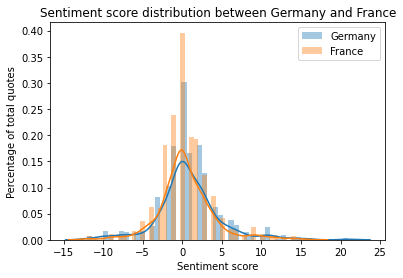

In [ ]:
# Plotting the distribution of sentiment scores 
ax = sns.distplot(ger_data['sentiment_score'], hist=True, label='Germany');
ax = sns.distplot(fra_data['sentiment_score'], hist=True, label='France')
ax.set(title='Sentiment score distribution between Germany and France',xlabel='Sentiment score', ylabel='Percentage of total quotes')
plt.legend()
plt.show()

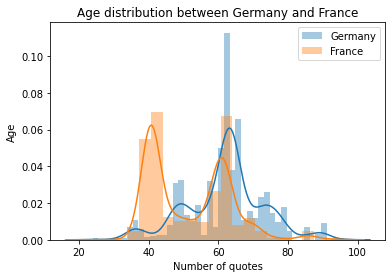

In [ ]:
# Plotting the age distribution of the speakers included to check if the propensity score matching would be a good fit for our problem
ax = sns.distplot(ger_data['age'], hist=True, label='Germany');
ax = sns.distplot(fra_data['age'], hist=True, label='France')
ax.set(title='Age distribution between Germany and France',xlabel='Number of quotes', ylabel='Age')
plt.legend()
plt.show()

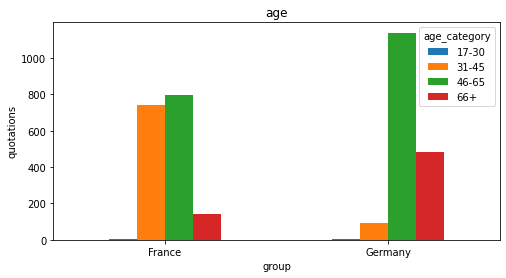

In [ ]:
import matplotlib.pyplot as plt

df_group = ger_and_fra_data.groupby(['nationality_label', 'age_category'])['age_category'].count()
df_group = df_group.unstack()
#df_group = df_group.div(df_group.sum(axis=1), axis=0)
pl = df_group.plot(kind='bar', figsize=[8,4], rot=0)
pl.set_title('age')
pl.set_ylabel('quotations')
pl.set_xlabel('group')
plt.show()

Since we observe differences in the ages of our speakers, we can perform a propensity score matching

In [ ]:
# calculating the propensity score matching and printing the model
ger_and_fra_data['n_label_binary'] = np.where(ger_and_fra_data['nationality_label'] == 'Germany', 1, 0)

mod = smf.logit(formula='n_label_binary ~ age', data=ger_and_fra_data)
res = mod.fit()
ger_and_fra_data['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.599299
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         n_label_binary   No. Observations:                 3405
Model:                          Logit   Df Residuals:                     3403
Method:                           MLE   Df Model:                            1
Date:                Mon, 13 Dec 2021   Pseudo R-squ.:                  0.1353
Time:                        19:56:30   Log-Likelihood:                -2040.6
converged:                       True   LL-Null:                       -2359.9
Covariance Type:            nonrobust   LLR p-value:                6.695e-141
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.4584      0.202    -22.065      0.000      -4.854      -4.062
age            0.0789      0.

In [ ]:
# calculating the similarity of every pair of speakers and adding them to a graph
ger_df = ger_and_fra_data[ger_and_fra_data['n_label_binary'] == 1]
fra_df = ger_and_fra_data[ger_and_fra_data['n_label_binary'] == 0]

G = nx.Graph()
i = 0
for ger_id, ger_row in ger_df.iterrows():
    for fra_id, fra_row in fra_df.iterrows():
      similarity = get_similarity(ger_row['Propensity_score'],
                                    fra_row['Propensity_score'])
      
      G.add_weighted_edges_from([(ger_id, fra_id, similarity)])

matching = nx.max_weight_matching(G)

In [ ]:
# creating a list of matched speakers
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

In [ ]:
# creating a new, balanced dataframe that contains only the matched pairs of speakers
balanced_df_all = ger_and_fra_data.loc[matched]

In [ ]:
# extracting countryies from the dataframe
ger = balanced_df_all.loc[balanced_df_all['n_label_binary'] == 1] #People from germany
fra = balanced_df_all.loc[balanced_df_all['n_label_binary'] == 0] #People from france

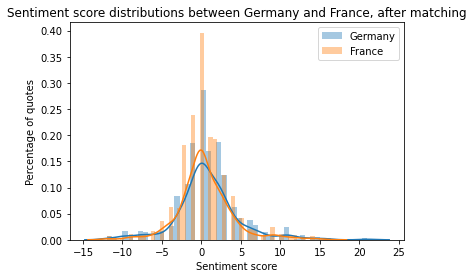

In [ ]:
# plotting the distribution of sentiment scores after the matching
ax = sns.distplot(ger['sentiment_score'], hist=True, label='Germany');
ax = sns.distplot(fra['sentiment_score'], hist=True, label='France')
ax.set(title='Sentiment score distributions between Germany and France, after matching',xlabel='Sentiment score', ylabel='Percentage of quotes')
plt.legend()
plt.show()

Based on the experiment above, we can observe that the two distributions of sentiment scores are close to each other, so there is a possibility that age **does not effect the sentiment scores!**

To be sure, we are performing the same experiment on two more pairs of countries:


*   Belgium and Indonesia
*   Chile and Finland



### For Belgium and Indonesia

In [ ]:
bel_data = df.loc[df['nationality_label'] == 'Belgium']
ind_data = df.loc[df['nationality_label'] == 'Indonesia']
bel_and_ind_data = df.loc[df['nationality_label'].isin(['Belgium', 'Indonesia'])]
ind_data.shape

(46, 21)

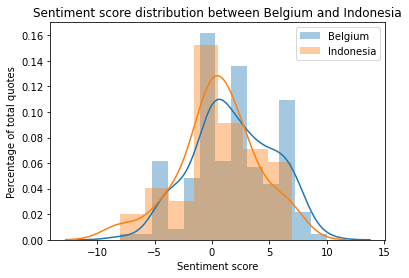

In [ ]:
ax = sns.distplot(bel_data['sentiment_score'], hist=True, label='Belgium');
ax = sns.distplot(ind_data['sentiment_score'], hist=True, label='Indonesia')
ax.set(title='Sentiment score distribution between Belgium and Indonesia',xlabel='Sentiment score', ylabel='Percentage of total quotes')
plt.legend()
plt.show()

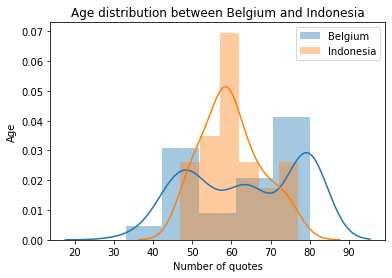

In [ ]:
ax = sns.distplot(bel_data['age'], hist=True, label='Belgium');
ax = sns.distplot(ind_data['age'], hist=True, label='Indonesia')
ax.set(title='Age distribution between Belgium and Indonesia',xlabel='Number of quotes', ylabel='Age')
plt.legend()
plt.show()

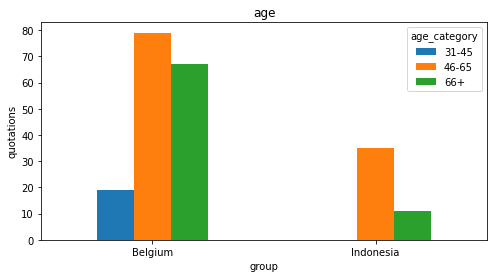

In [ ]:
import matplotlib.pyplot as plt

df_group = bel_and_ind_data.groupby(['nationality_label', 'age_category'])['age_category'].count()
df_group = df_group.unstack()
#df_group = df_group.div(df_group.sum(axis=1), axis=0)
pl = df_group.plot(kind='bar', figsize=[8,4], rot=0)
pl.set_title('age')
pl.set_ylabel('quotations')
pl.set_xlabel('group')
plt.show()

In [ ]:
bel_and_ind_data['n_label_binary'] = np.where(bel_and_ind_data['nationality_label'] == 'Belgium', 1, 0)

mod = smf.logit(formula='n_label_binary ~ age', data=bel_and_ind_data)
res = mod.fit()
bel_and_ind_data['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.518038
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         n_label_binary   No. Observations:                  211
Model:                          Logit   Df Residuals:                      209
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Dec 2021   Pseudo R-squ.:                 0.01209
Time:                        17:07:42   Log-Likelihood:                -109.31
converged:                       True   LL-Null:                       -110.64
Covariance Type:            nonrobust   LLR p-value:                    0.1019
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0233      0.807     -0.029      0.977      -1.605       1.559
age            0.0211      0.

In [ ]:
bel_df = bel_and_ind_data[bel_and_ind_data['n_label_binary'] == 1]
ind_df = bel_and_ind_data[bel_and_ind_data['n_label_binary'] == 0]

G = nx.Graph()
i = 0
for bel_id, bel_row in bel_df.iterrows():
    for ind_id, ind_row in ind_df.iterrows():
      similarity = get_similarity(bel_row['Propensity_score'],
                                    ind_row['Propensity_score'])
      
      G.add_weighted_edges_from([(bel_id, ind_id, similarity)])

matching = nx.max_weight_matching(G)

In [ ]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

In [ ]:
balanced_df_all = bel_and_ind_data.loc[matched]
balanced_df_all.shape

(92, 23)

In [ ]:
bel = balanced_df_all.loc[balanced_df_all['n_label_binary'] == 1] #People from belgium
ind = balanced_df_all.loc[balanced_df_all['n_label_binary'] == 0] #People from indonesia

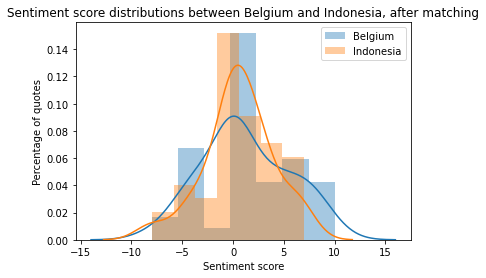

In [ ]:
ax = sns.distplot(bel['sentiment_score'], hist=True, label='Belgium');
ax = sns.distplot(ind['sentiment_score'], hist=True, label='Indonesia')
ax.set(title='Sentiment score distributions between Belgium and Indonesia, after matching',xlabel='Sentiment score', ylabel='Percentage of quotes')
plt.legend()
plt.show()

### For Finland and Chile

In [ ]:
fin_data = df.loc[df['nationality_label'] == 'Finland']
chi_data = df.loc[df['nationality_label'] == 'Chile']
fin_and_chi_data = df.loc[df['nationality_label'].isin(['Finland', 'Chile'])]
chi_data.shape

(73, 21)

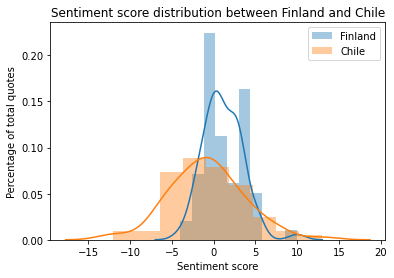

In [ ]:
ax = sns.distplot(fin_data['sentiment_score'], hist=True, label='Finland');
ax = sns.distplot(chi_data['sentiment_score'], hist=True, label='Chile')
ax.set(title='Sentiment score distribution between Finland and Chile',xlabel='Sentiment score', ylabel='Percentage of total quotes')
plt.legend()
plt.show()

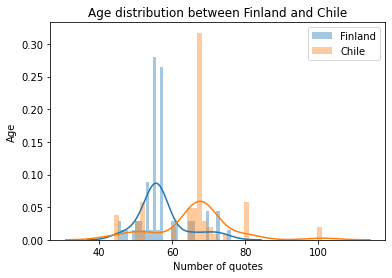

In [ ]:
ax = sns.distplot(fin_data['age'], hist=True, label='Finland');
ax = sns.distplot(chi_data['age'], hist=True, label='Chile')
ax.set(title='Age distribution between Finland and Chile',xlabel='Number of quotes', ylabel='Age')
plt.legend()
plt.show()

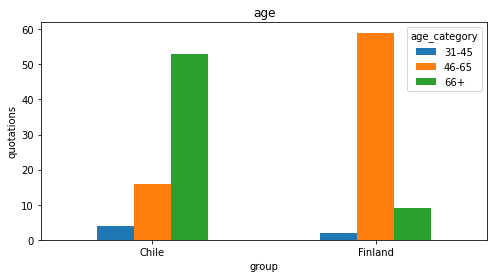

In [ ]:
import matplotlib.pyplot as plt

df_group = fin_and_chi_data.groupby(['nationality_label', 'age_category'])['age_category'].count()
df_group = df_group.unstack()
#df_group = df_group.div(df_group.sum(axis=1), axis=0)
pl = df_group.plot(kind='bar', figsize=[8,4], rot=0)
pl.set_title('age')
pl.set_ylabel('quotations')
pl.set_xlabel('group')
plt.show()

In [ ]:
fin_and_chi_data['n_label_binary'] = np.where(fin_and_chi_data['nationality_label'] == 'Finland', 1, 0)

mod = smf.logit(formula='n_label_binary ~ age', data=fin_and_chi_data)
res = mod.fit()
fin_and_chi_data['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.563060
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         n_label_binary   No. Observations:                  143
Model:                          Logit   Df Residuals:                      141
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Dec 2021   Pseudo R-squ.:                  0.1874
Time:                        17:16:42   Log-Likelihood:                -80.518
converged:                       True   LL-Null:                       -99.089
Covariance Type:            nonrobust   LLR p-value:                 1.098e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0854      1.576      5.132      0.000       4.997      11.173
age           -0.1326      0.

In [ ]:
fin_df = fin_and_chi_data[fin_and_chi_data['n_label_binary'] == 1]
chi_df = fin_and_chi_data[fin_and_chi_data['n_label_binary'] == 0]

G = nx.Graph()
i = 0
for fin_id, fin_row in fin_df.iterrows():
    for chi_id, chi_row in chi_df.iterrows():
      similarity = get_similarity(fin_row['Propensity_score'],
                                    chi_row['Propensity_score'])
      
      G.add_weighted_edges_from([(fin_id, chi_id, similarity)])

matching = nx.max_weight_matching(G)

In [ ]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

In [ ]:
balanced_df_all = fin_and_chi_data.loc[matched]
balanced_df_all.shape

(140, 23)

In [ ]:
fin = balanced_df_all.loc[balanced_df_all['n_label_binary'] == 1] #People from Finland
chi = balanced_df_all.loc[balanced_df_all['n_label_binary'] == 0] #People from Chile

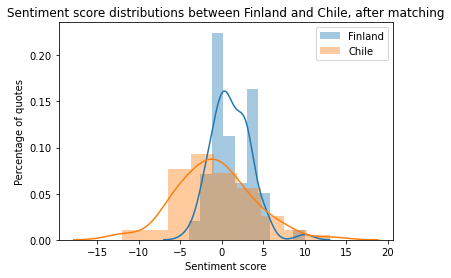

In [ ]:
ax = sns.distplot(fin['sentiment_score'], hist=True, label='Finland');
ax = sns.distplot(chi['sentiment_score'], hist=True, label='Chile')
ax.set(title='Sentiment score distributions between Finland and Chile, after matching',xlabel='Sentiment score', ylabel='Percentage of quotes')
plt.legend()
plt.show()

After performing three experiement on different country pairs we can observe that not so much has changed in the sentiment score distributions after we matched the speakers based on their age.

The final conclusion is that age does not affect the sentiment scores.

# Detecting climate change denial

## Creation of the model

We have labeled manually 962 randomly chosen quotes from the dataset to train a machine-learning algorithm to detect the quotes about global warming denial.

In [ ]:
# load the climate skepticism pickle (~1000 randomly selected quotes manually labeled)
# https://drive.google.com/file/d/1jA9oeJAL-u2XOhCSl0tXGv6_39EC0WAd/view?usp=sharing
path_pickle_skepticism_labeled = '/content/drive/MyDrive/pickle_skepticism_labeled'
climate_skepticism_labeled = load_pickle(path_pickle_skepticism_labeled)
print(climate_skepticism_labeled.shape)
print(climate_skepticism_labeled.groupby(['skepticism']).count().quotation)
climate_skepticism_labeled.sample(3)

(962, 4)
skepticism
0    939
1     23
Name: quotation, dtype: int64


,quoteID,quotation,speaker,skepticism
44885,2017-06-09-085689,Our job: To help you come work with us on our ...,Emmanuel Macron,0
14201,2015-11-30-056683,"It is a unique sector, the only established in...",Stuart Goodall,0
152752,2020-01-15-064924,Paper Cup is a song about getting older and re...,Martin Courtney,0


Only 23 are labeled positively as climate change denial. Because of this, we add 38 climate skepticism quotes from another dataset. That brought our labeled set to exactly 1000 quotes.

In [ ]:
# because the number of climate denial quotes is low, we add some to the dataset to enhance the training
# load the climate skepticism addition file
# https://docs.google.com/spreadsheets/d/1XVe76HhNV6bD6cMTkoH0It27GdhT0ZNn/edit?usp=sharing&ouid=112197025629432322656&rtpof=true&sd=true
# from https://skepticalscience.com/skepticquotes.php/debunking-climate-myths-from-politicians.html
skepticism_addition_file_path = '/content/drive/MyDrive/skeptical_quotes.xlsx'
skepticism_addition = pd.read_excel(skepticism_addition_file_path)

# concatenate the additional quotes with the labeled database
climate_skepticism_labeled_clean = climate_skepticism_labeled[['quotation', 'speaker', 'skepticism']]
skepticism_addition['skepticism'] = '1'
climate_skepticism_all = pd.concat([climate_skepticism_labeled_clean, skepticism_addition], ignore_index=True)
print(climate_skepticism_all.shape)
print(climate_skepticism_all.groupby(['skepticism']).count().quotation)
climate_skepticism_all.sample(3)

(1000, 3)
skepticism
0    939
1     61
Name: quotation, dtype: int64


,quotation,speaker,skepticism
832,Our knowledge on ecosystem conditions is limit...,Pierre Failler,0
629,Jim Davidson was stuck at the front-got out of...,Tom Edwards,0
586,The low oxygen problem is the biggest unknown ...,Lisa Levin,0


We split the data between a train and a test set. We tokenize the quotes, remove the stop words, transforme them in term frequency-inverse document frequency (TF-IDF) matrix, and keep the 20 top components using singular value decomposition.

In [ ]:
# remove punctuation and lower all the chars
EXCLUDE_CHARS = set(punctuation).union(set('’'))
def clean_line(line):
    for char in EXCLUDE_CHARS:
        line = line.replace(char, ' ')
    return line.lower()
climate_skepticism_all['quotation'] = climate_skepticism_all['quotation'].apply(clean_line)

# create the train and the test set
X = climate_skepticism_all['quotation']
y = climate_skepticism_all['skepticism']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# transform X into a TF-IDF matrix
nltk.download('stopwords')
def simple_tokeniser(text):
    return text.split()
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'), tokenizer=simple_tokeniser, min_df=2)
train_vectors = tfidf.fit_transform(X_train)
test_vectors = tfidf.transform(X_test)

# keep only the 20 top concepts with SVD
svd = TruncatedSVD(n_components=20)
train_svd = svd.fit_transform(train_vectors)
test_svd = svd.transform(test_vectors)

train_labels = pd.to_numeric(y_train)
test_labels = pd.to_numeric(y_test)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We train multiple times several machine learning algorithms (logistic regression, random forest classifier, KNN, linear neural network) to see which one had the best results. 

In [ ]:
# to test a model an print the scores
def test_model(model, model_name):
  model.fit(train_svd, train_labels)
  train_pred = model.predict(train_svd)
  test_pred = model.predict(test_svd)

  accuracy = accuracy_score(test_labels, test_pred)
  precision = precision_score(test_labels, test_pred)
  recall = recall_score(test_labels, test_pred)
  f1 = f1_score(test_labels, test_pred)
  confusion = confusion_matrix(test_labels, test_pred)
  print(model_name + ": ")
  # print(np.unique(test_pred, return_counts=True))
  print("accuracy: " + str(accuracy))
  print("precision: " + str(precision))
  print("recall: " + str(recall))
  print("f1 score: " + str(f1))
  print("confusion matrix: ")
  print(confusion)

In [ ]:
# logistic regression
log_reg_model = LogisticRegressionCV(cv=10)
test_model(log_reg_model, "Logistic regression")

Logistic regression: 
accuracy: 0.94
precision: 1.0
recall: 0.2
f1 score: 0.33333333333333337
confusion matrix: 
[[185   0]
 [ 12   3]]


In [ ]:
# random forest classifier
forest_model = RandomForestClassifier()
test_model(forest_model, "Random forest classifier")

Random forest classifier: 
accuracy: 0.935
precision: 1.0
recall: 0.13333333333333333
f1 score: 0.23529411764705882
confusion matrix: 
[[185   0]
 [ 13   2]]


In [ ]:
# KNN classifier
knn_model = KNeighborsClassifier()
test_model(knn_model, "KNN classifier")

KNN classifier: 
accuracy: 0.925
precision: 0.5
recall: 0.2
f1 score: 0.28571428571428575
confusion matrix: 
[[182   3]
 [ 12   3]]


In [ ]:
# prepare the data to use Pytorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # "cuda:0" or "cpu"
train_svd_tensor = torch.from_numpy(train_svd).float().to(device)
train_labels_tensor = torch.from_numpy(train_labels.to_numpy()).float().unsqueeze(1).to(device)
test_svd_tensor = torch.from_numpy(test_svd).float().to(device)
test_labels_tensor = torch.from_numpy(test_labels.to_numpy()).float().unsqueeze(1).to(device)

In [ ]:
# to train a model, plots the loss and the accuracy
def train_model_graph(model, train_input, train_target, test_input, test_target, epochs, mini_batch, graph_title):
    loss_list = []
    acc_list = []
    prec_list = []
    rec_list = []
    f1_list = []
    for e in range(epochs):
        loss_sum = 0
        for b in range(0, train_input.size(0), mini_batch):
            optimizer.zero_grad()
            output = model(train_input.narrow(0, b, mini_batch))
            loss = criterion(output, train_target.narrow(0, b, mini_batch))
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

        model.eval()
        test_target_pred = model(test_input).ge(.5).view(-1).int()
        accuracy = accuracy_score(test_target, test_target_pred)
        precision = precision_score(test_target, test_target_pred)
        recall = recall_score(test_target, test_target_pred)
        f1 = f1_score(test_target, test_target_pred)
        model.train()
          
        loss_list.append(loss_sum)
        acc_list.append(accuracy)
        prec_list.append(precision)
        rec_list.append(recall)
        f1_list.append(f1)

    plt.figure(1, figsize=(8, 8))

    plt.subplot(321)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.plot(range(1,len(loss_list)+1), loss_list)

    plt.subplot(322)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.plot(range(1,len(acc_list)+1), acc_list)

    plt.subplot(323)
    plt.xlabel('epochs')
    plt.ylabel('precision')
    plt.plot(range(1,len(prec_list)+1), prec_list)

    plt.subplot(324)
    plt.xlabel('epochs')
    plt.ylabel('recall')
    plt.plot(range(1,len(rec_list)+1), rec_list)

    plt.subplot(325)
    plt.xlabel('epochs')
    plt.ylabel('f1')
    plt.plot(range(1,len(f1_list)+1), f1_list)

    plt.tight_layout(pad=3.5)
    plt.suptitle(graph_title, fontsize=14)
    plt.show()

    print()
    print("Maximum accuracy:", max(acc_list))
    print("Final accuracy:", acc_list[-1])
    print("Final precision:", prec_list[-1])
    print("Final recall:", rec_list[-1])
    print("Final f1 score:", f1_list[-1])
    print("Confusion matrix:")
    print(confusion_matrix(test_target, test_target_pred))

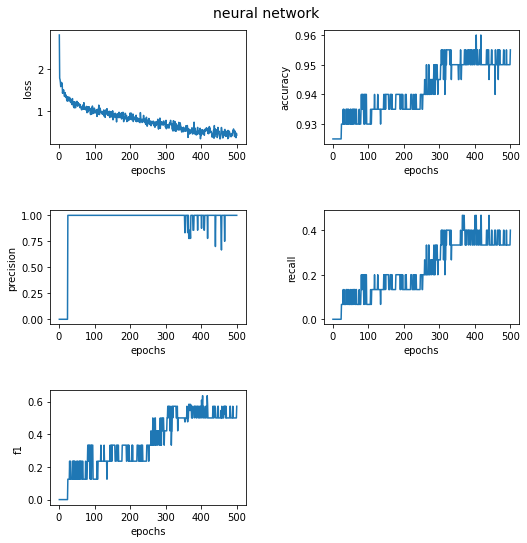


Maximum accuracy: 0.96
Final accuracy: 0.955
Final precision: 1.0
Final recall: 0.4
Final f1 score: 0.5714285714285715
Confusion matrix:
[[185   0]
 [  9   6]]


In [ ]:
# train a linear neural network
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc1 = nn.Linear(20, 200)
        self.bn1 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.fc3 = nn.Linear(100, 30)
        self.bn3 = nn.BatchNorm1d(30)
        self.fc4 = nn.Linear(30, 1)
        self.dropout = nn.Dropout(0.8)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

model = LinearNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.5)
epochs = 500
mini_batch = 100

criterion.to(device)

train_model_graph(model, train_svd_tensor, train_labels_tensor, test_svd_tensor, 
                  test_labels_tensor, epochs, mini_batch, "neural network")

Our results are not very good. The models we tried have some difficulties finding the climate change denial quotes. They miss a lot of them (poor recall). However, the precision is not so bad (between 0.5 and 1 depending on the model). To have better results, more quotes should have been labeled but we did not have the time to do it. 

To be able to compare the climate change denial between two categories of population, precision is more important because it is better to know that true climate skeptical quotes have been selected even if some have been missed. Because of that, we are going to use our logistic regression model that has the most consistent high precision in our runs.

## Evaluating all the quotes

We apply our model to all the quotations about climate change and we compute the percentage of climate change denial quotes in the different age categories and in the different US political parties.

In [ ]:
# we take all our quotes about climate change
df_wikidata = climate_wikidata_ages

# remove punctuation and lower all the chars
X = df_wikidata['quotation'].apply(clean_line)

# transform X into a TF-IDF matrix
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'), tokenizer=simple_tokeniser, min_df=2)
matrix = tfidf.fit_transform(X)

# keep only the 20 top concepts with SVD
svd = TruncatedSVD(n_components=20)
matrix_svd = svd.fit_transform(matrix)

In [ ]:
# make the predictions with the previously trained model (logistic regression)
prediction = log_reg_model.predict(matrix_svd)
df_wikidata['skepticism'] = prediction
df_wikidata.groupby(['skepticism']).count().quotation

skepticism
0    73971
1      442
Name: quotation, dtype: int64

Text(0, 0.5, 'political party')

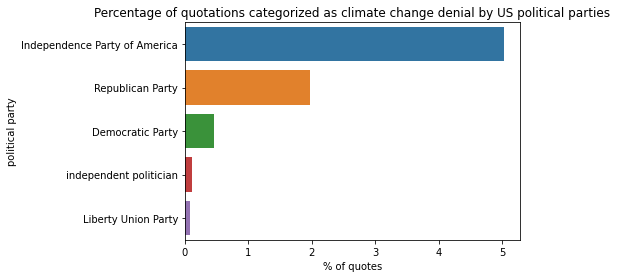

In [ ]:
# compute the percentage of climate change denial quotes in the biggest US political parties
df_wikidata_US = df_wikidata[df_wikidata.nationality_label == 'United States of America']
parties_total = df_wikidata_US.groupby(by='party_label').count().quotation
parties_skepticism = df_wikidata_US[df_wikidata_US.skepticism == 1].groupby(by='party_label').count().quotation
parties_total_df = pd.DataFrame(parties_total).reset_index()
parties_skepticism_df = pd.DataFrame(parties_skepticism).reset_index()
parties_df = parties_skepticism_df.merge(parties_total_df, left_on='party_label', right_on='party_label', suffixes=('_x', '_y'))
parties_df['percent_skepticism'] = (parties_df['quotation_x'] / parties_df['quotation_y']) * 100
parties_df = parties_df[parties_df['quotation_y'] > 1000]
parties_df.sort_values(by=['percent_skepticism'], ascending=False, inplace=True)

# plt.figure(figsize=(10, 7))
plt.title("Percentage of quotations categorized as climate change denial by US political parties")
sns.barplot(x='percent_skepticism', y='party_label', data=parties_df)
plt.xlabel("% of quotes")
plt.ylabel("political party")

We see that in the US, the Republican seem to deny a lot more climate change than the Democrat.

Text(0, 0.5, 'age category')

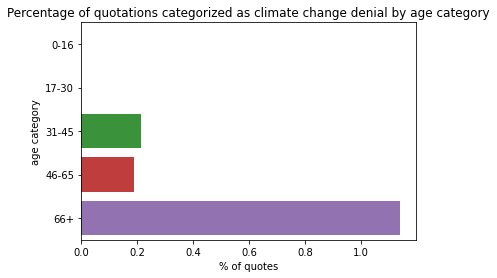

In [ ]:
# compute the percentage of climate change denial quotes by age categories
age_total = df_wikidata.groupby(by='age_category').count().quotation
age_skepticism = df_wikidata[df_wikidata.skepticism == 1].groupby(by='age_category').count().quotation
age_total_df = pd.DataFrame(age_total).reset_index()
age_skepticism_df = pd.DataFrame(age_skepticism).reset_index()
age_df = age_total_df.merge(age_skepticism_df, how='left', left_on='age_category', right_on='age_category', suffixes=('_x', '_y')).fillna(0)
age_df['percent_skepticism'] = (age_df['quotation_y'] / age_df['quotation_x']) * 100

# plt.figure(figsize=(10, 7))
plt.title("Percentage of quotations categorized as climate change denial by age category")
sns.barplot(x='percent_skepticism', y='age_category', data=age_df)
plt.xlabel("% of quotes")
plt.ylabel("age category")

We see that people above 66 years deny a lot more climate change.